In [2]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

import theano
theano.config.gcc__cxxflags += " -fexceptions"

starry.config.lazy = False
starry.config.quiet = True

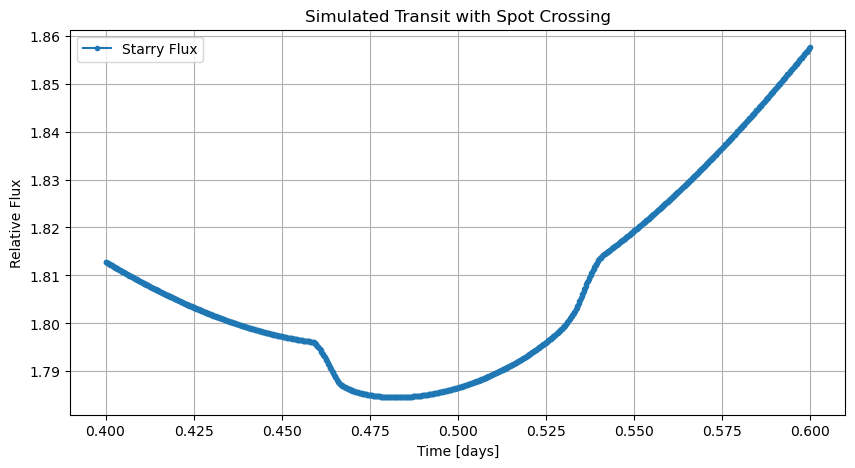

In [ ]:


# #----------------------------------------------------
# # 1. Generate Example Starry Data with a Spot Transit
# #----------------------------------------------------
# # Stellar/Planetary/Spot Parameters (EXAMPLE)
# ydeg = 15         # Map resolution
# udeg = 2          # Limb darkening degree
# inc = 87.0        # Inclination [deg]
# obl = 0.0         # Obliquity [deg]
# rp = 0.1          # Planet radius [stellar radii]
# porb = 1.0        # Orbital period [days]
# prot = 2.0        # Stellar rotation period [days]
# t0 = 0.5          # Transit midpoint time [days]
# spot_lat = 10.0   # Spot latitude [deg]
# spot_lon = 0.0    # Spot longitude (crosses mid-transit) [deg]
# spot_rad_sigma = 0.1 # Spot radius (gaussian sigma)
# spot_intensity = -0.7 # Spot intensity relative to photosphere (negative = dark)

# # Starry setup
# map = starry.Map(ydeg=ydeg, udeg=udeg, inc=inc, obl=obl)

# # Add limb darkening (quadratic)
# map[1] = 0.4
# map[2] = 0.2

# # Set stellar rotation period (needed for spot evolution if prot != inf)
# # map.prot = prot # Not strictly needed if only rendering one transit phase

# # Add the spot - use add_spot for gaussian profiles
# # We use 'intensity' and relative=False for simplicity here
# # Note: add_spot adds the *signal* of the spot.
# # A dark spot has negative intensity relative to a baseline map.
# # When occulted, this *negative* signal is removed, causing an *upward* flux bump.
# # To get an *upward* bump, we model the spot itself as being *darker*.
# # The 'intensity' param in add_spot is the *fractional change* at the spot center.
# # So, intensity=-0.7 means the spot center is 30% as bright as the surroundings.
# map.add_spot(intensity=spot_intensity, relative=False, # Relative to quiet photosphere
#              sigma=spot_rad_sigma, lat=spot_lat, lon=spot_lon)

# # Planet setup
# planet = starry.kepler.Primary(map, m=1, r=1, prot=prot) # Star details
# sec = starry.kepler.Secondary(map, # The map is required but not used for flux calc
#                                m=0, r=rp, porb=porb, t0=t0, inc=inc)
# system = starry.System(planet, sec)

# # Time array centered on transit
# time = np.linspace(t0 - 0.1, t0 + 0.1, 1000)
# flux = system.flux(time)

# # Optional: Add some noise
# # noise_level = 50e-6 # 50 ppm
# # noise = np.random.normal(0, noise_level, len(time))
# # flux += noise

# # Plot the generated light curve
# plt.figure(figsize=(10, 5))
# plt.plot(time, flux, '.-', label='Starry Flux')
# plt.xlabel("Time [days]")
# plt.ylabel("Relative Flux")
# plt.title("Simulated Transit with Spot Crossing")
# plt.legend()
# plt.grid(True)
# plt.show()

#its bad

Text(0, 0.5, 'Flux [normalized]')

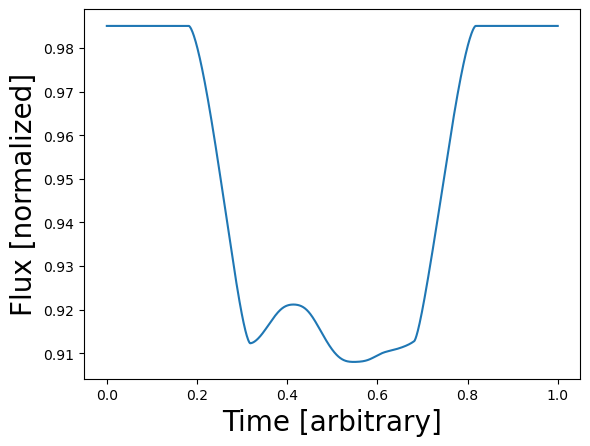

In [3]:
loaded_light_curve = np.load("light_curve_1.npy")
loaded_time=np.load("time_lc_1.npy")

flux=loaded_light_curve
time=loaded_time


plt.plot(time, flux)
plt.xlabel("Time [arbitrary]", fontsize=20)
plt.ylabel("Flux [normalized]", fontsize=20)


--- Running Naive Spot Model ---
Identified transit between indices 304 and 434
Transit time range: 0.3043 - 0.4344
Found bump peak at index 309 (local index 5)
1) Estimated Spot Center Time: 0.3093 days
2) Estimated Spot Contrast Proxy (bump_height/transit_depth): 0.0017
3) Estimated Spot Radius Proxy (bump duration): 0.0079 days


KeyError: 'width_heights'

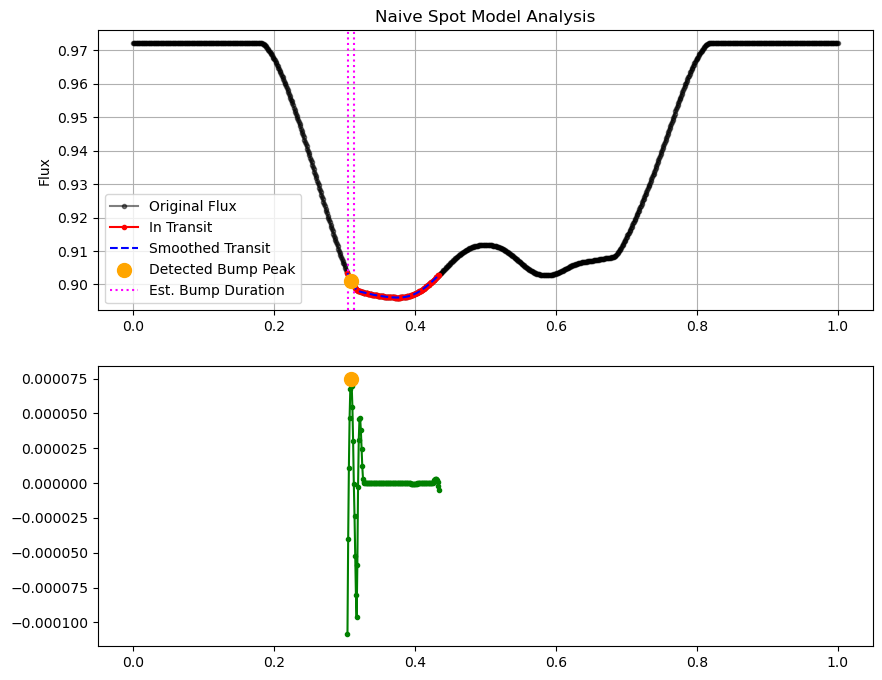

In [ ]:
#----------------------------------------------------
# 2. Naive Spot Model Function
#----------------------------------------------------
def naive_spot_model(time, flux, plot_results=True):
    """
    Analyzes a light curve to naively detect a spot bump during transit.

    Args:
        time (array): Time values of the light curve.
        flux (array): Flux values of the light curve.
        plot_results (bool): If True, plots the analysis steps.

    Returns:
        dict or None: A dictionary containing 'center_time', 'contrast_proxy',
                      'duration_proxy' if a spot bump is found, otherwise None.
    """
    results = {}
    print("\n--- Running Naive Spot Model ---")

    # --- Identify Transit ---
    # Assume baseline is median flux (robust to outliers/transit)
    baseline_flux = np.median(flux)
    # Find points significantly below baseline
    # transit_indices = np.where(flux < (baseline_flux - 0.85 * (baseline_flux - np.min(flux))))[0]
    transit_indices = np.where(flux < (baseline_flux))[0]

    if len(transit_indices) < 5: # Need a few points to define transit
        print("ERROR: Could not clearly identify transit dip.")
        return None

    t_start_idx, t_end_idx = transit_indices[0], transit_indices[-1]
    # Add a small buffer if possible
    t_start_idx = max(0, t_start_idx - 2)
    t_end_idx = min(len(time) - 1, t_end_idx + 2)

    in_transit_time = time[t_start_idx:t_end_idx+1]
    in_transit_flux = flux[t_start_idx:t_end_idx+1]

    if len(in_transit_flux) < 5: # Need points for smoothing/peak finding
        print("ERROR: Not enough data points identified within transit.")
        return None

    print(f"Identified transit between indices {t_start_idx} and {t_end_idx}")
    print(f"Transit time range: {in_transit_time[0]:.4f} - {in_transit_time[-1]:.4f}")

    # --- Find the Bump ---
    # Smooth the in-transit flux to get a baseline transit shape
    # Window size should be large enough to smooth noise/small bumps,
    # but smaller than the transit duration. Let's try ~15% of transit points.
    window_length = max(5, int(0.15 * len(in_transit_flux)))
    if window_length % 2 == 0: window_length += 1 # Must be odd for savgol
    try:
        smoothed_flux = savgol_filter(in_transit_flux, window_length=window_length, polyorder=2)
    except ValueError as e:
         print(f"ERROR: Smoothing failed ({e}). Check window_length vs data length.")
         return None

    # Calculate the difference (residuals) - positive values indicate upward bumps
    flux_diff = in_transit_flux - smoothed_flux

    # Find peaks in the difference signal
    # Require peaks to be somewhat significant relative to noise/smoothing artifacts
    std_dev_diff = np.std(flux_diff)
    # prominence: height relative to surrounding minima
    # height: absolute height of the peak
    peaks, properties = find_peaks(flux_diff, height=1.0*std_dev_diff, prominence=1.0*std_dev_diff)

    if len(peaks) == 0:
        print("No significant upward bump found within the transit.")
        if plot_results: # Plot even if no peak found for debugging
            plt.figure(figsize=(10, 8))
            ax1 = plt.subplot(2, 1, 1)
            plt.plot(time, flux, 'k.-', label='Original Flux', alpha=0.5)
            plt.plot(in_transit_time, in_transit_flux, '.-', color='red', label='In Transit')
            plt.plot(in_transit_time, smoothed_flux, '--', color='blue', label='Smoothed Transit')
            plt.ylabel("Flux")
            plt.title("Transit Identification and Smoothing")
            plt.legend()
            plt.grid(True)

            plt.subplot(2, 1, 2, sharex=ax1)
            plt.plot(in_transit_time, flux_diff, '.-', color='green', label='Flux - Smoothed')
            plt.axhline(0, color='grey', linestyle=':')
            plt.axhline(std_dev_diff, color='orange', linestyle='--', label='1-sigma threshold')
            plt.ylabel("Flux Difference")
            plt.xlabel("Time [days]")
            plt.title("Difference Signal (Potential Bumps)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        return None

    # Assume the largest peak is our spot bump
    # (Could be extended to handle multiple bumps)
    best_peak_idx_local = peaks[np.argmax(properties['peak_heights'])]
    best_peak_idx_global = t_start_idx + best_peak_idx_local
    bump_height = properties['peak_heights'][np.argmax(properties['peak_heights'])]

    print(f"Found bump peak at index {best_peak_idx_global} (local index {best_peak_idx_local})")

    # --- Calculate Properties ---
    # 1) Center of the stellar spot (based on time of bump peak)
    center_time = time[best_peak_idx_global]
    results['center_time'] = center_time
    print(f"1) Estimated Spot Center Time: {center_time:.4f} days")

    # 2) Contrast of the stellar spot (proxy: bump height / transit depth)
    transit_bottom_flux = np.min(in_transit_flux) # Simplistic transit bottom
    # transit_bottom_flux = smoothed_flux[best_peak_idx_local] # Alternative: use smoothed value at peak time
    transit_depth = baseline_flux - transit_bottom_flux
    if transit_depth <= 0:
        print("Warning: Calculated transit depth is zero or negative. Cannot estimate contrast.")
        contrast_proxy = np.nan
    else:
        contrast_proxy = bump_height / transit_depth
    results['contrast_proxy'] = contrast_proxy
    print(f"2) Estimated Spot Contrast Proxy (bump_height/transit_depth): {contrast_proxy:.4f}")

    # 3) Radius of the stellar spot (proxy: width/duration of the bump)
    # Use the width property from find_peaks at half the prominence (common definition)
    # This requires scipy 1.1.0 or later for width calculation in find_peaks.
    # If not available, we can manually estimate.
    try:
        peak_widths = find_peaks(flux_diff, height=1.0*std_dev_diff, prominence=1.0*std_dev_diff, width=1)[1]['widths']
        bump_width_points = peak_widths[np.argmax(properties['peak_heights'])]
        time_step = np.mean(np.diff(time)) # Average time step
        duration_proxy = bump_width_points * time_step
    except (IndexError, KeyError, TypeError):
         print("Warning: Could not estimate peak width automatically. Using simpler FWHM estimate.")
         # Manual FWHM estimate: Find where diff drops to half its peak height around the peak
         half_height = bump_height / 2.0
         left_idx = best_peak_idx_local
         while left_idx > 0 and flux_diff[left_idx-1] > half_height:
             left_idx -= 1
         right_idx = best_peak_idx_local
         while right_idx < len(flux_diff) - 1 and flux_diff[right_idx+1] > half_height:
             right_idx += 1
         duration_proxy = in_transit_time[right_idx] - in_transit_time[left_idx]

    results['duration_proxy'] = duration_proxy
    print(f"3) Estimated Spot Radius Proxy (bump duration): {duration_proxy:.4f} days")


    # --- Plotting ---
    if plot_results:
        plt.figure(figsize=(10, 8))

        # Top plot: Flux and model components
        ax1 = plt.subplot(2, 1, 1)
        plt.plot(time, flux, 'k.-', label='Original Flux', alpha=0.5)
        plt.plot(in_transit_time, in_transit_flux, '.-', color='red', label='In Transit')
        plt.plot(in_transit_time, smoothed_flux, '--', color='blue', label='Smoothed Transit')
        plt.scatter(time[best_peak_idx_global], flux[best_peak_idx_global],
                    color='orange', s=100, zorder=5, label='Detected Bump Peak')
        # Plot estimated duration lines
        t_start_bump = center_time - duration_proxy / 2.0
        t_end_bump = center_time + duration_proxy / 2.0
        plt.axvline(t_start_bump, color='magenta', linestyle=':', label='Est. Bump Duration')
        plt.axvline(t_end_bump, color='magenta', linestyle=':')
        plt.ylabel("Flux")
        plt.title("Naive Spot Model Analysis")
        plt.legend()
        plt.grid(True)

        # Bottom plot: Difference signal and peak finding
        plt.subplot(2, 1, 2, sharex=ax1)
        plt.plot(in_transit_time, flux_diff, '.-', color='green', label='Flux - Smoothed')
        plt.scatter(in_transit_time[best_peak_idx_local], flux_diff[best_peak_idx_local],
                    color='orange', s=100, zorder=5, label='Detected Peak')
        plt.hlines(properties['width_heights'], properties['left_ips']*time_step + in_transit_time[0], properties['right_ips']*time_step + in_transit_time[0], color="magenta", linestyle="-.")

        plt.axhline(0, color='grey', linestyle=':')
        #plt.axhline(std_dev_diff, color='orange', linestyle='--', label='1-sigma threshold')
        plt.ylabel("Flux Difference")
        plt.xlabel("Time [days]")
        plt.title("Difference Signal and Detected Bump Features")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    print("--- Naive Spot Model Finished ---")
    return results

#----------------------------------------------------
# 3. Run the Naive Model on the Starry Data
#----------------------------------------------------
spot_info = naive_spot_model(time, flux, plot_results=True)

if spot_info:
    print("\nSummary of Naive Spot Properties:")
    for key, value in spot_info.items():
        print(f"- {key}: {value:.4f}")
else:
    print("\nNaive model did not detect a qualifying spot bump.")

#----------------------------------------------------
# Comparison with True Values (Rough Check)
#----------------------------------------------------
if spot_info:
    print("\nComparison with True Input Values (approximate):")
    print(f"- True Spot Center Time (t0 + offset): {t0:.4f}") # Spot was at lon=0, so crosses at t0
    print(f"- Estimated Spot Center Time: {spot_info['center_time']:.4f}")

    # True contrast is complex, depends on limb darkening, spot shape, impact parameter.
    # The 'intensity' param (-0.7) means spot is 0.3 * photospheric intensity.
    # The bump height depends on area occulted. This proxy is very rough.
    print(f"- Input Spot Intensity Param: {spot_intensity:.4f}")
    print(f"- Estimated Contrast Proxy: {spot_info['contrast_proxy']:.4f}")

    # True duration depends on spot size, planet speed, impact parameter.
    # Planet speed ~ 2*pi*a / Porb. Stellar radius R*. Chord length relates to radius.
    # Very rough estimate: Duration ~ 2 * (spot_radius_stellar * R*) / (planet_speed)
    # Using spot_rad_sigma ~ spot radius in radians: spot_radius_stellar ~ spot_rad_sigma
    # Planet speed relative to R*: v_rel = 2*pi*a/R* / Porb = 2*pi*(a/R*) / Porb
    # Assuming circular orbit, a/R* ~ (G Mstar Porb^2 / (4 pi^2 R*^3))^(1/3) ~ 1 / rp * (Mpl/Mstar)^(1/3) ?? - This gets complicated fast.
    # Simpler: v_rel ~ 2 * R_stellar / T_duration, where T_duration ~ 2*rp*Porb/pi for central transit
    # Duration ~ 2 * spot_rad_sigma / v_rel_radians_per_day
    # v_rel_radians_per_day ~ 2*pi / Porb * (a/R_star) ? No.
    # Angular speed of planet across star: approx 2*pi / Porb * (a / R_star) ?
    # Chord length: 2 * sqrt(rp^2 - impact_param^2) * Rstar
    # Transit duration T14 ~ Porb / pi * asin(sqrt((Rstar+rp)^2 - b^2) / a) -> complex
    # Simpler Approx: Duration ~ (2 * SpotDiameterInStellarRadii) / (PlanetSpeedInStellarRadiiPerDay)
    # PlanetSpeed ~ (2 * pi * a) / Porb. Need 'a'. Kepler's 3rd? Need Mstar.
    # Easier: Planet crosses 2*R_star in roughly T_duration. Speed ~ 2 / T_duration (in R*/day)
    # T_duration ~ time[-1] - time[0] where flux < baseline - rp*depth...
    # Very crude: T_duration ~ time[t_end_idx] - time[t_start_idx]
    transit_duration_est = time[t_end_idx] - time[t_start_idx]
    planet_speed_est = (2 * rp) / transit_duration_est # Roughly stellar radii per day (diameter/duration)
    true_duration_est = (2 * spot_rad_sigma) / planet_speed_est # Very rough! (spot diameter / speed)

    print(f"- Input Spot Sigma (proxy for radius in radians): {spot_rad_sigma:.4f}")
    print(f"- Very Crude Expected Duration: {true_duration_est:.4f} days")
    print(f"- Estimated Duration Proxy: {spot_info['duration_proxy']:.4f}")


--- Running Naive Spot Model ---
Identified transit between indices 247 and 750
Transit time range: 0.2472 - 0.7508


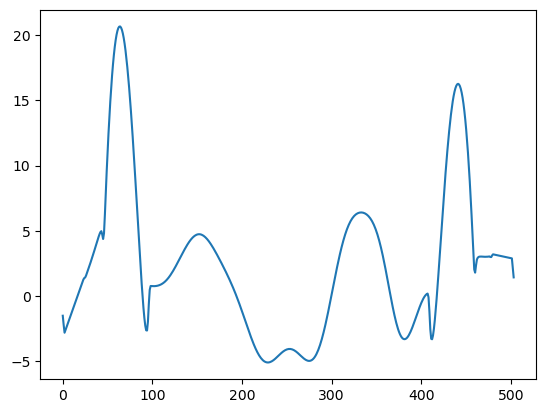

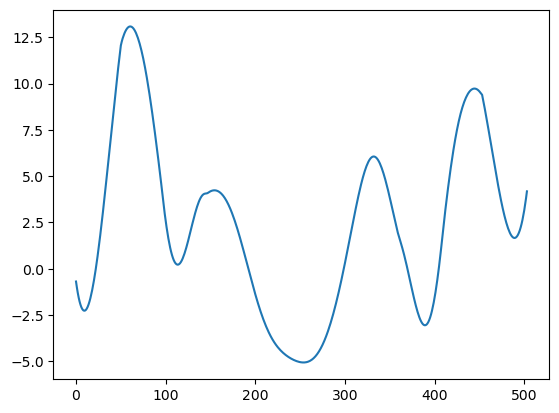

In [ ]:
def naive_spot_model(time, flux, plot_results=True):
    """
    Analyzes a light curve to naively detect a spot bump during transit.

    Args:
        time (array): Time values of the light curve.
        flux (array): Flux values of the light curve.
        plot_results (bool): If True, plots the analysis steps.

    Returns:
        dict or None: A dictionary containing 'center_time', 'contrast_proxy',
                      'duration_proxy' if a spot bump is found, otherwise None.
    """
    results = {}
    print("\n--- Running Naive Spot Model ---")

    # --- Identify Transit ---
    # Assume baseline is median flux (robust to outliers/transit)
    baseline_flux = np.median(flux)
    # Find points significantly below baseline
    # transit_indices = np.where(flux < (baseline_flux - 0.85 * (baseline_flux - np.min(flux))))[0]
    transit_indices = np.where(flux < (baseline_flux))[0]

    if len(transit_indices) < 5: # Need a few points to define transit
        print("ERROR: Could not clearly identify transit dip.")
        return None

    t_start_idx, t_end_idx = transit_indices[0], transit_indices[-1]
    # Add a small buffer if possible
    t_start_idx = max(0, t_start_idx - 2)
    t_end_idx = min(len(time) - 1, t_end_idx + 2)

    in_transit_time = time[t_start_idx:t_end_idx+1]
    in_transit_flux = flux[t_start_idx:t_end_idx+1]

    if len(in_transit_flux) < 5: # Need points for smoothing/peak finding
        print("ERROR: Not enough data points identified within transit.")
        return None

    print(f"Identified transit between indices {t_start_idx} and {t_end_idx}")
    print(f"Transit time range: {in_transit_time[0]:.4f} - {in_transit_time[-1]:.4f}")


    # --- Smooth the data and Calculate Derivatives ---
    # Smoothing is CRITICAL for second derivatives
    window_length = max(7, int(0.1 * len(in_transit_flux))) # Smaller window than before? Test.
    if window_length % 2 == 0: window_length += 1 # Must be odd
    polyorder = 3 # Polynomial order for Savitzky-Golay

    try:
        smoothed_flux = savgol_filter(in_transit_flux, window_length=window_length, polyorder=polyorder)
        # Calculate first derivative of smoothed flux
        d1f_smooth = np.gradient(smoothed_flux, in_transit_time)
        # Calculate second derivative of smoothed flux
        d2f_smooth = np.gradient(d1f_smooth, in_transit_time)

        # plt.plot(smoothed_flux)
        # plt.show()
        # plt.plot(d1f_smooth)
        # plt.show()
        # plt.plot(d2f_smooth)

        #Make a running average of d2f_smooth
        plt.plot(d2f_smooth)
        plt.show()

        d2f_smooth = savgol_filter(d2f_smooth, window_length=101, polyorder=polyorder)
        plt.plot(d2f_smooth)
    except ValueError as e:
         print(f"ERROR: Smoothing or derivative calculation failed ({e}). Check window_length/polyorder vs data length.")
         return None


naive_spot_model(time, flux, plot_results=True)


--- Running Naive Spot Model (MINIMUM Second Derivative Method) ---
Identified potential transit region between indices 246 and 751
Time range: 0.2462 - 0.7518
Found minimum d2f at index 476 (local index 230) with value -5.08e+00
NOTE: Minimum d2f often corresponds to inflection points or 'shoulders', not necessarily the peak.
1) Estimated Feature Center Time (from min d2f): 0.4765 days
2) Estimated Contrast Proxy (height_at_min_d2f / transit_depth): 0.0003
   (Actual peak flux difference near this time is 1.65e-05 at t=0.4705)
3) Estimated Spot Radius Proxy (FWHM of flux diff near feature): 0.0322 days


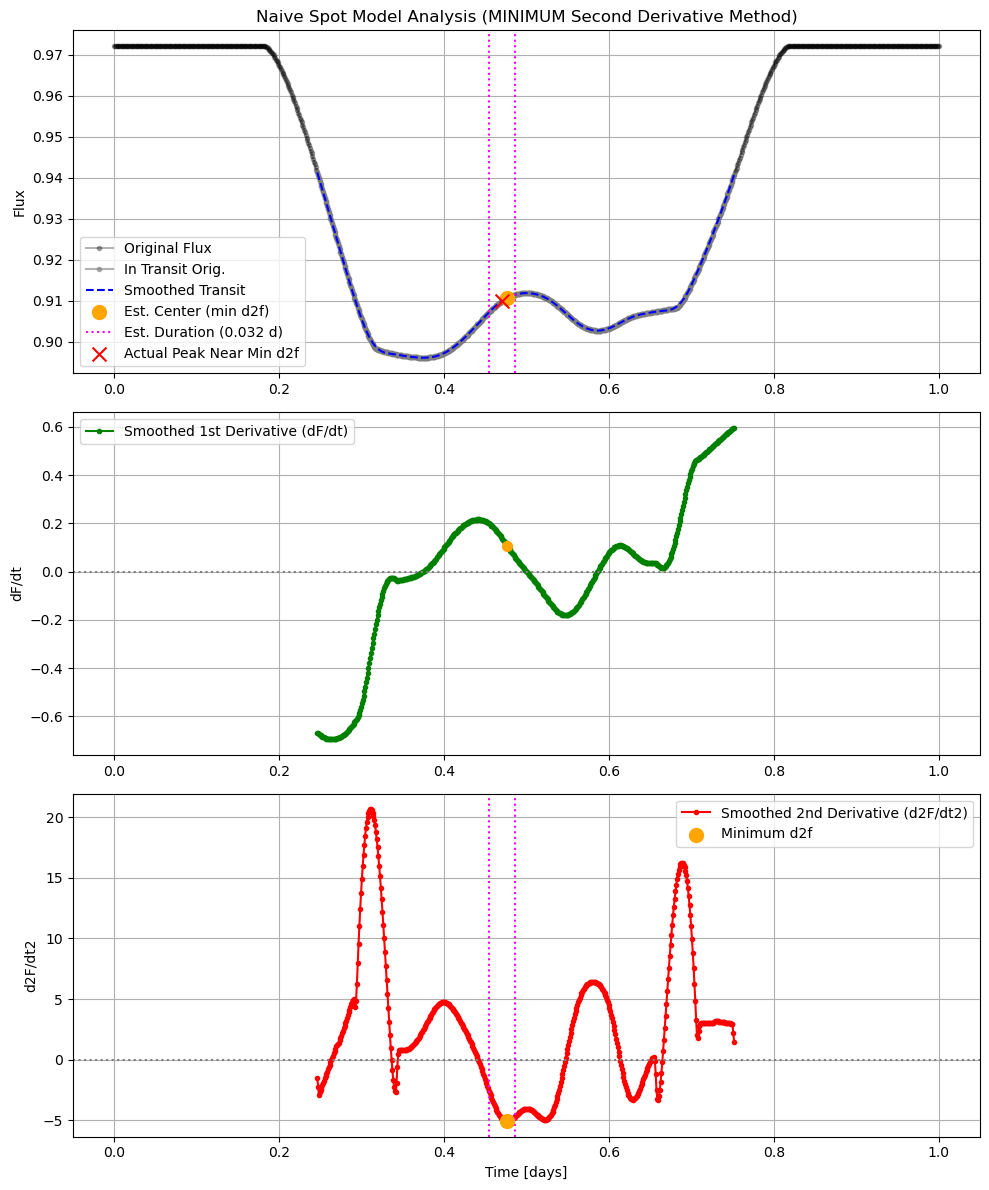

--- Naive Spot Model (Min d2F/dt2) Finished ---

Summary of Naive Spot Properties (Min d2F/dt2 method):
- center_time: 0.4765
- contrast_proxy: 0.0003
- duration_proxy: 0.0322


In [34]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks



#----------------------------------------------------
# 2. Naive Spot Model Function (using MINIMUM Second Derivative)
#----------------------------------------------------
def naive_spot_model_min_deriv2(time, flux, plot_results=True):
    """
    Analyzes a light curve using the MINIMUM (most negative) second derivative
    to naively locate features potentially related to a spot bump during transit.

    Args:
        time (array): Time values of the light curve.
        flux (array): Flux values of the light curve.
        plot_results (bool): If True, plots the analysis steps.

    Returns:
        dict or None: A dictionary containing 'center_time', 'contrast_proxy',
                      'duration_proxy' if a feature is found, otherwise None.
    """
    results = {}
    print("\n--- Running Naive Spot Model (MINIMUM Second Derivative Method) ---")

    # --- Identify Transit (same as before) ---
    baseline_flux = np.median(flux)
    transit_indices = np.where(flux < baseline_flux)[0]
    if len(transit_indices) < 10:
        print("ERROR: Could not clearly identify transit dip or not enough points.")
        return None
    blocks = np.split(transit_indices, np.where(np.diff(transit_indices) != 1)[0]+1)
    longest_block = max(blocks, key=len)
    if len(longest_block) < 10:
         print("ERROR: Longest block of points below baseline is too short.")
         return None
    t_start_idx, t_end_idx = longest_block[0], longest_block[-1]
    t_start_idx = max(0, t_start_idx - 3)
    t_end_idx = min(len(time) - 1, t_end_idx + 3)
    in_transit_time = time[t_start_idx:t_end_idx+1]
    in_transit_flux = flux[t_start_idx:t_end_idx+1]
    if len(in_transit_flux) < 10:
        print("ERROR: Not enough data points identified within transit after buffering.")
        return None
    print(f"Identified potential transit region between indices {t_start_idx} and {t_end_idx}")
    print(f"Time range: {in_transit_time[0]:.4f} - {in_transit_time[-1]:.4f}")

    # --- Smooth the data and Calculate Derivatives (same as before) ---
    window_length = max(7, int(0.1 * len(in_transit_flux)))
    if window_length % 2 == 0: window_length += 1
    polyorder = 3
    try:
        smoothed_flux = savgol_filter(in_transit_flux, window_length=window_length, polyorder=polyorder)
        d1f_smooth = np.gradient(smoothed_flux, in_transit_time)
        d2f_smooth = np.gradient(d1f_smooth, in_transit_time)
    except ValueError as e:
         print(f"ERROR: Smoothing or derivative calculation failed ({e}). Check window_length/polyorder vs data length.")
         return None

    # --- Find Feature using MINIMUM Second Derivative ---
    # Look for the minimum (most negative) value of the second derivative.
    # This indicates the point of strongest *downward* curvature (∩ shape).
    edge_buffer = max(1, window_length // 2)
    if len(d2f_smooth) <= 2 * edge_buffer:
        print("ERROR: Not enough points for stable derivative analysis after removing edges.")
        return None

    search_range_d2f = d2f_smooth[edge_buffer:-edge_buffer]
    if len(search_range_d2f) == 0:
        print("ERROR: Search range for d2f is empty.")
        return None

    min_d2f_index_local = np.argmin(search_range_d2f) + edge_buffer # Index within in_transit_flux
    min_d2f_value = d2f_smooth[min_d2f_index_local]

    # Check if the minimum is actually negative (indicating downward concavity)
    if min_d2f_value >= 0:
        print(f"Minimum d2f ({min_d2f_value:.2e}) is not negative. No strong downward concavity found.")
        # Plotting for debugging
        if plot_results:
             plt.figure(figsize=(10, 10))
             # Top plot: Flux and model components
             ax1 = plt.subplot(3, 1, 1); plt.plot(time, flux, 'k.-', alpha=0.3); plt.plot(in_transit_time, smoothed_flux, 'b--'); plt.ylabel("Flux"); plt.title("Min d2f Analysis: No Negative Found"); plt.grid(True)
             # Middle plot: First Derivative
             ax2 = plt.subplot(3, 1, 2, sharex=ax1); plt.plot(in_transit_time, d1f_smooth, 'g.-'); plt.ylabel("dF/dt"); plt.grid(True)
             # Bottom plot: Second Derivative
             ax3 = plt.subplot(3, 1, 3, sharex=ax1); plt.plot(in_transit_time, d2f_smooth, 'r.-'); plt.ylabel("d2F/dt2"); plt.axhline(0, color='grey', ls=':'); plt.xlabel("Time"); plt.grid(True)
             plt.tight_layout(); plt.show()
        return None # Stop if no significant downward concavity is found

    best_feature_idx_local = min_d2f_index_local
    best_feature_idx_global = t_start_idx + best_feature_idx_local

    print(f"Found minimum d2f at index {best_feature_idx_global} (local index {best_feature_idx_local}) with value {min_d2f_value:.2e}")
    print("NOTE: Minimum d2f often corresponds to inflection points or 'shoulders', not necessarily the peak.")

    # --- Calculate Properties (Anchored to the min d2f time) ---
    # 1) Center Time (using time of min d2f)
    center_time = time[best_feature_idx_global]
    results['center_time'] = center_time
    print(f"1) Estimated Feature Center Time (from min d2f): {center_time:.4f} days")

    # 2) Contrast Proxy (using bump height relative to smooth curve AT min d2f time)
    flux_diff = in_transit_flux - smoothed_flux
    # Height above smoothed curve at the MIN d2f time. Might not be the peak height!
    height_at_min_d2f = flux_diff[best_feature_idx_local]

    transit_bottom_flux = np.min(smoothed_flux)
    transit_depth = baseline_flux - transit_bottom_flux
    if transit_depth <= 1e-9:
        print("Warning: Calculated transit depth is near zero. Cannot estimate contrast.")
        contrast_proxy = np.nan
    else:
        # Height here might be small if min d2f is on the shoulder
        if height_at_min_d2f < 0:
             print(f"Warning: Flux difference ({height_at_min_d2f:.2e}) is negative at min d2f location.")
        contrast_proxy = height_at_min_d2f / transit_depth
    results['contrast_proxy'] = contrast_proxy
    print(f"2) Estimated Contrast Proxy (height_at_min_d2f / transit_depth): {contrast_proxy:.4f}")
    # Let's also find the ACTUAL peak height near this time for comparison
    try:
        local_search_indices = np.arange(max(0, best_feature_idx_local-window_length//2),
                                          min(len(flux_diff), best_feature_idx_local+window_length//2))
        if len(local_search_indices)>0:
            actual_peak_idx_local = local_search_indices[np.argmax(flux_diff[local_search_indices])]
            actual_peak_height = flux_diff[actual_peak_idx_local]
            actual_peak_time = in_transit_time[actual_peak_idx_local]
            print(f"   (Actual peak flux difference near this time is {actual_peak_height:.2e} at t={actual_peak_time:.4f})")
    except Exception:
        pass # Ignore errors in finding actual peak


    # 3) Duration Proxy (Using FWHM of the flux_diff bump around the min d2f time)
    #    This seems more robust than using d2f zero-crossings here.
    duration_proxy = np.nan # Default
    try:
        # Find peaks in the positive flux_diff signal to identify the bump itself
        peaks_diff, properties_diff = find_peaks(flux_diff, height=0) # Find all positive peaks
        if len(peaks_diff) > 0:
            # Find the peak closest to our min_d2f location
            closest_peak_idx_local = peaks_diff[np.argmin(np.abs(in_transit_time[peaks_diff] - center_time))]
            # Get FWHM for this closest peak
            results_fwhm = find_peaks(flux_diff, height=0, width=1) # Recalculate with width arg
            peak_idx_in_fwhm_results = np.where(results_fwhm[0] == closest_peak_idx_local)[0]

            if len(peak_idx_in_fwhm_results) > 0:
                width_points = results_fwhm[1]['widths'][peak_idx_in_fwhm_results[0]]
                time_step = np.mean(np.diff(in_transit_time))
                duration_proxy = width_points * time_step
            else:
                 print("Warning: Could not match peak to calculate FWHM.")
        else:
            print("Warning: Could not find any positive peaks in flux_diff for duration estimate.")

    except Exception as e:
        print(f"Warning: Error during FWHM duration estimation: {e}")

    results['duration_proxy'] = duration_proxy
    print(f"3) Estimated Spot Radius Proxy (FWHM of flux diff near feature): {duration_proxy:.4f} days")


    # --- Plotting ---
    if plot_results:
        plt.figure(figsize=(10, 12))

        # Top plot: Flux and model components
        ax1 = plt.subplot(3, 1, 1)
        plt.plot(time, flux, 'k.-', label='Original Flux', alpha=0.3)
        plt.plot(in_transit_time, in_transit_flux, '.-', color='grey', label='In Transit Orig.', alpha=0.6)
        plt.plot(in_transit_time, smoothed_flux, '--', color='blue', label='Smoothed Transit')
        plt.scatter(time[best_feature_idx_global], flux[best_feature_idx_global],
                    color='orange', s=100, zorder=5, label='Est. Center (min d2f)')
        if not np.isnan(duration_proxy):
             # Center duration estimate around the actual peak time if found
             duration_center = actual_peak_time if 'actual_peak_time' in locals() else center_time
             t_start_bump = duration_center - duration_proxy / 2.0
             t_end_bump = duration_center + duration_proxy / 2.0
             plt.axvline(t_start_bump, color='magenta', linestyle=':', label=f'Est. Duration ({duration_proxy:.3f} d)')
             plt.axvline(t_end_bump, color='magenta', linestyle=':')
        if 'actual_peak_time' in locals():
            plt.scatter(actual_peak_time, in_transit_flux[actual_peak_idx_local],
                        color='red', marker='x', s=100, zorder=5, label='Actual Peak Near Min d2f')

        plt.ylabel("Flux")
        plt.title("Naive Spot Model Analysis (MINIMUM Second Derivative Method)")
        plt.legend()
        plt.grid(True)

        # Middle plot: First Derivative
        ax2 = plt.subplot(3, 1, 2, sharex=ax1)
        plt.plot(in_transit_time, d1f_smooth, '.-', color='green', label='Smoothed 1st Derivative (dF/dt)')
        plt.axhline(0, color='grey', linestyle=':')
        plt.scatter(time[best_feature_idx_global], d1f_smooth[best_feature_idx_local],
                    color='orange', s=50, zorder=5)
        plt.ylabel("dF/dt")
        plt.legend()
        plt.grid(True)

        # Bottom plot: Second Derivative
        ax3 = plt.subplot(3, 1, 3, sharex=ax1)
        plt.plot(in_transit_time, d2f_smooth, '.-', color='red', label='Smoothed 2nd Derivative (d2F/dt2)')
        plt.axhline(0, color='grey', linestyle=':')
        plt.scatter(time[best_feature_idx_global], d2f_smooth[best_feature_idx_local],
                    color='orange', s=100, zorder=5, label='Minimum d2f')
        if not np.isnan(duration_proxy):
             plt.axvline(t_start_bump, color='magenta', linestyle=':')
             plt.axvline(t_end_bump, color='magenta', linestyle=':')

        plt.ylabel("d2F/dt2")
        plt.xlabel("Time [days]")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    print("--- Naive Spot Model (Min d2F/dt2) Finished ---")
    return results

#----------------------------------------------------
# 3. Run the Naive Model on the Starry Data
#----------------------------------------------------
spot_info_min_d2 = naive_spot_model_min_deriv2(time, flux, plot_results=True)

if spot_info_min_d2:
    print("\nSummary of Naive Spot Properties (Min d2F/dt2 method):")
    for key, value in spot_info_min_d2.items():
        print(f"- {key}: {value:.4f}")
else:
    print("\nNaive model (Min d2F/dt2) did not detect a qualifying feature.")

#----------------------------------------------------
# Comparison with True Values (Rough Check)
#----------------------------------------------------
# (Add comparison code similar to the previous versions if desired)
# ...


--- Running Naive Spot Model (Min d2f Center, d1f Duration Rule) ---
Identified potential transit region: t=[0.2442, 0.7538]
Found feature time (min d2f) at index 476: t=0.4765
Estimated transit center time (Midpoint of buffered range): 0.4990
Identified bump region (d1f rule) from t=0.3754 to t=0.5856
3) Estimated Spot Radius Proxy (Duration from d1f rule): 0.2102 days
   Found actual peak diff 1.65e-05 at t=0.4705
2) Estimated Contrast Proxy (peak_height / transit_depth): 0.0004


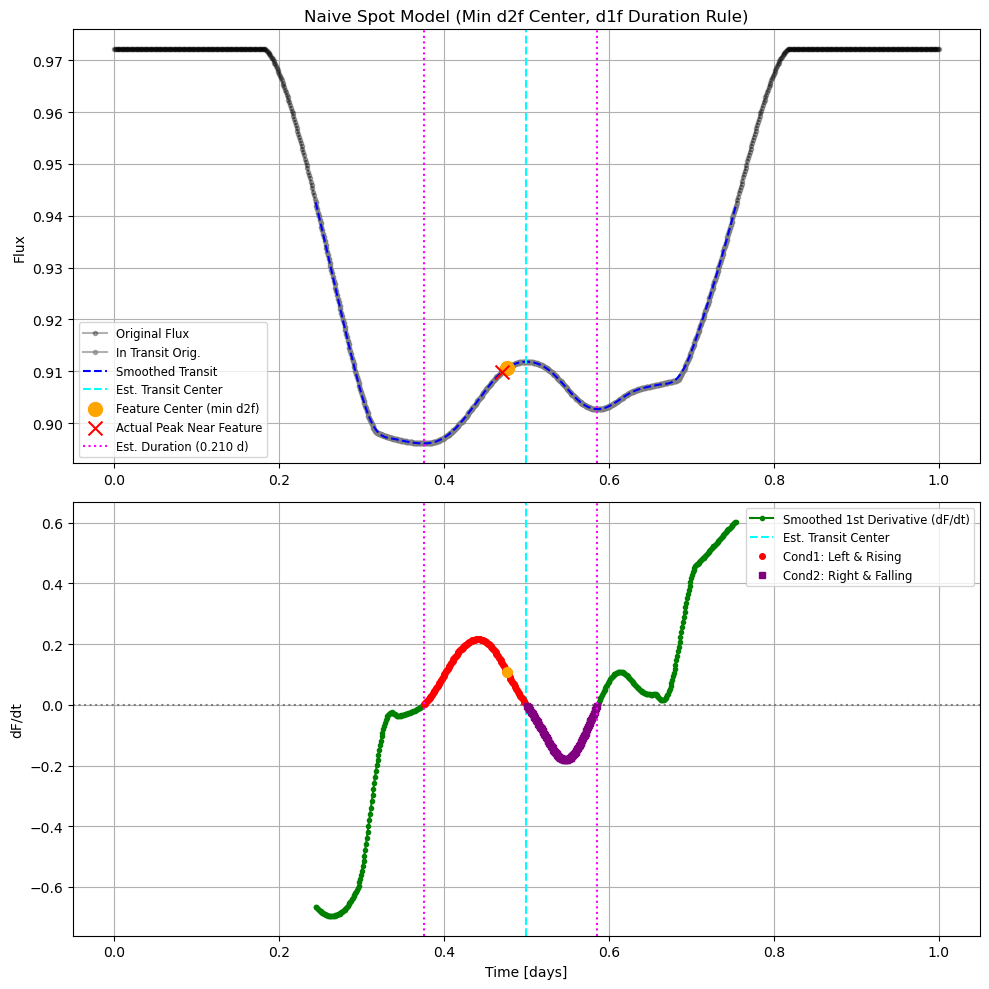

--- Naive Spot Model Finished ---

Summary of Naive Spot Properties (Min d2f Center, d1f Duration):
- center_time: 0.4765
- duration_proxy: 0.2102
- t_start_bump: 0.3754
- t_end_bump: 0.5856
- contrast_proxy: 0.0004


In [ ]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks # Keep find_peaks for contrast calc maybe


#----------------------------------------------------
# 2. Modified Naive Spot Model Function
#----------------------------------------------------
def naive_spot_model_deriv_duration(time, flux, plot_results=True):
    """
    Analyzes a light curve, identifies a feature using minimum d2f/dt2,
    and estimates the bump duration based on the sign of the first derivative
    relative to the transit center.

    Args:
        time (array): Time values of the light curve.
        flux (array): Flux values of the light curve.
        plot_results (bool): If True, plots the analysis steps.

    Returns:
        dict or None: A dictionary containing 'center_time' (from min d2f),
                      'contrast_proxy', 'duration_proxy' (from d1f rule)
                      if a feature and duration are found, otherwise None.
    """
    results = {}
    print("\n--- Running Naive Spot Model (Min d2f Center, d1f Duration Rule) ---")

    # --- Identify Transit (Robust version) ---
    baseline_flux = np.median(flux)
    transit_indices = np.where(flux < baseline_flux)[0]
    if len(transit_indices) < 10: print("ERROR: Could not clearly identify transit dip."); return None
    blocks = np.split(transit_indices, np.where(np.diff(transit_indices) != 1)[0]+1)
    longest_block = max(blocks, key=len, default=[])
    if len(longest_block) < 10: print("ERROR: Longest block below baseline too short."); return None
    t_start_idx, t_end_idx = longest_block[0], longest_block[-1]
    # Buffer slightly more for derivative stability
    t_start_idx = max(0, t_start_idx - 5)
    t_end_idx = min(len(time) - 1, t_end_idx + 5)
    in_transit_time = time[t_start_idx:t_end_idx+1]
    in_transit_flux = flux[t_start_idx:t_end_idx+1]
    if len(in_transit_flux) < 10: print("ERROR: Not enough points in transit after buffering."); return None
    print(f"Identified potential transit region: t=[{in_transit_time[0]:.4f}, {in_transit_time[-1]:.4f}]")

    # --- Smooth the data and Calculate Derivatives ---
    window_length = max(7, int(0.1 * len(in_transit_flux))) # Smoothing for derivatives
    if window_length % 2 == 0: window_length += 1
    polyorder = 3
    try:
        # Smoothing applied to in-transit data
        smoothed_flux = savgol_filter(in_transit_flux, window_length=window_length, polyorder=polyorder)
        d1f_smooth = np.gradient(smoothed_flux, in_transit_time)
        d2f_smooth = np.gradient(d1f_smooth, in_transit_time)
    except ValueError as e:
         print(f"ERROR: Smoothing/derivative failed ({e})."); return None

    # --- Find Feature using MINIMUM Second Derivative (Optional - used for 'center_time') ---
    # This part still finds *a* feature time, maybe a shoulder.
    # If you prefer centering on the *peak* of the bump, revert to the *first*
    # method (finding peak in flux - smoothed_flux). But let's keep min d2f for now.
    feature_center_time = np.nan # Default
    edge_buffer = max(1, window_length // 2)
    if len(d2f_smooth) > 2 * edge_buffer:
        search_range_d2f = d2f_smooth[edge_buffer:-edge_buffer]
        if len(search_range_d2f) > 0:
            min_d2f_index_local = np.argmin(search_range_d2f) + edge_buffer
            min_d2f_value = d2f_smooth[min_d2f_index_local]
            if min_d2f_value < 0: # Only accept if actually negative concavity found
                 best_feature_idx_local = min_d2f_index_local
                 best_feature_idx_global = t_start_idx + best_feature_idx_local
                 feature_center_time = time[best_feature_idx_global]
                 print(f"Found feature time (min d2f) at index {best_feature_idx_global}: t={feature_center_time:.4f}")
            else:
                 print("Min d2f was not negative, feature time not identified this way.")
        else:
             print("Search range for min d2f was empty.")
    else:
        print("Not enough points for stable min d2f analysis.")

    results['center_time'] = feature_center_time # Store the time found (might be NaN)

    # --- Estimate Transit Center Time (using min of smoothed flux) ---
    transit_center_time = (in_transit_time[0] + in_transit_time[-1]) / 2.0
    print(f"Estimated transit center time (Midpoint of buffered range): {transit_center_time:.4f}")


    # --- Calculate Bump Duration using Derivative Sign Rule ---
    duration_proxy = np.nan
    t_start_bump = np.nan
    t_end_bump = np.nan

    # Define conditions based on derivative sign relative to transit center
    is_left = in_transit_time < transit_center_time
    is_right = in_transit_time > transit_center_time
    is_rising = d1f_smooth > 0
    is_falling = d1f_smooth < 0

    # Condition 1: Left side, but rising
    cond1 = is_left & is_rising
    # Condition 2: Right side, but falling
    cond2 = is_right & is_falling

    # Combine: Points belonging to the bump region based on slope anomaly
    is_bump_region = cond1 | cond2

    # Find indices where the bump condition is met
    bump_indices_local = np.where(is_bump_region)[0]

    if len(bump_indices_local) > 0:
        start_bump_idx_local = bump_indices_local[0]
        end_bump_idx_local = bump_indices_local[-1]

        t_start_bump = in_transit_time[start_bump_idx_local]
        t_end_bump = in_transit_time[end_bump_idx_local]
        duration_proxy = t_end_bump - t_start_bump

        print(f"Identified bump region (d1f rule) from t={t_start_bump:.4f} to t={t_end_bump:.4f}")
        print(f"3) Estimated Spot Radius Proxy (Duration from d1f rule): {duration_proxy:.4f} days")
    else:
        print("3) No bump region found using the d1f rule.")

    results['duration_proxy'] = duration_proxy
    results['t_start_bump'] = t_start_bump # Store start/end times as well
    results['t_end_bump'] = t_end_bump


    # --- Calculate Contrast Proxy (using peak height near feature_center_time if available) ---
    contrast_proxy = np.nan
    flux_diff = in_transit_flux - smoothed_flux # Difference from smooth curve

    if not np.isnan(feature_center_time): # Only calculate if feature center was found
        # Find actual peak of the difference signal near the feature time
        try:
            # Search within +/- half window width around the feature time
            search_start = max(0, best_feature_idx_local - window_length // 2)
            search_end = min(len(flux_diff), best_feature_idx_local + window_length // 2)
            local_search_indices = np.arange(search_start, search_end)

            if len(local_search_indices) > 0:
                actual_peak_idx_local = local_search_indices[np.argmax(flux_diff[local_search_indices])]
                actual_peak_height = flux_diff[actual_peak_idx_local]
                actual_peak_time = in_transit_time[actual_peak_idx_local]

                transit_bottom_flux = np.min(smoothed_flux)
                transit_depth = baseline_flux - transit_bottom_flux
                if transit_depth > 1e-9:
                    contrast_proxy = actual_peak_height / transit_depth
                    print(f"   Found actual peak diff {actual_peak_height:.2e} at t={actual_peak_time:.4f}")
                    print(f"2) Estimated Contrast Proxy (peak_height / transit_depth): {contrast_proxy:.4f}")
                else:
                    print("2) Transit depth near zero, cannot calculate contrast proxy.")
            else:
                 print("2) Could not find peak difference near feature time.")
        except Exception as e:
            print(f"2) Error calculating contrast proxy: {e}")
    else:
        print("2) Feature center time not identified, skipping contrast calculation.")

    results['contrast_proxy'] = contrast_proxy


    # --- Plotting ---
    if plot_results:
        plt.figure(figsize=(10, 10)) # Reduced height as only 2 plots needed now

        # Top plot: Flux and model components
        ax1 = plt.subplot(2, 1, 1)
        plt.plot(time, flux, 'k.-', label='Original Flux', alpha=0.3)
        plt.plot(in_transit_time, in_transit_flux, '.-', color='grey', label='In Transit Orig.', alpha=0.6)
        plt.plot(in_transit_time, smoothed_flux, '--', color='blue', label='Smoothed Transit')
        plt.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center')

        if not np.isnan(feature_center_time):
            plt.scatter(feature_center_time, smoothed_flux[best_feature_idx_local], # Plot on smoothed curve
                        color='orange', marker='o', s=100, zorder=5, label='Feature Center (min d2f)')
        if 'actual_peak_time' in locals():
             plt.scatter(actual_peak_time, in_transit_flux[actual_peak_idx_local],
                         color='red', marker='x', s=100, zorder=5, label='Actual Peak Near Feature')

        # Highlight the duration calculated by the d1f rule
        if not np.isnan(duration_proxy):
             plt.axvline(t_start_bump, color='magenta', linestyle=':', label=f'Est. Duration ({duration_proxy:.3f} d)')
             plt.axvline(t_end_bump, color='magenta', linestyle=':')
             # Optional: shade the region
             # plt.fill_between(in_transit_time[start_bump_idx_local:end_bump_idx_local+1],
             #                  smoothed_flux[start_bump_idx_local:end_bump_idx_local+1],
             #                  in_transit_flux[start_bump_idx_local:end_bump_idx_local+1],
             #                  where=is_bump_region[start_bump_idx_local:end_bump_idx_local+1], # Apply condition
             #                  color='lightcoral', alpha=0.4, label='d1f Anomaly Region')


        plt.ylabel("Flux")
        plt.title("Naive Spot Model (Min d2f Center, d1f Duration Rule)")
        plt.legend(fontsize='small')
        plt.grid(True)

        # Bottom plot: First Derivative and Conditions
        ax2 = plt.subplot(2, 1, 2, sharex=ax1)
        plt.plot(in_transit_time, d1f_smooth, '.-', color='green', label='Smoothed 1st Derivative (dF/dt)')
        plt.axhline(0, color='grey', linestyle=':')
        plt.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center')

        # Highlight points satisfying the conditions
        if len(bump_indices_local) > 0:
            cond1_indices = np.where(cond1)[0]
            cond2_indices = np.where(cond2)[0]
            plt.plot(in_transit_time[cond1_indices], d1f_smooth[cond1_indices], 'o', color='red', ms=4, label='Cond1: Left & Rising')
            plt.plot(in_transit_time[cond2_indices], d1f_smooth[cond2_indices], 's', color='purple', ms=4, label='Cond2: Right & Falling')

        if not np.isnan(feature_center_time):
            plt.scatter(feature_center_time, d1f_smooth[best_feature_idx_local],
                        color='orange', marker='o', s=50, zorder=5) # Mark feature time on d1f plot

        if not np.isnan(duration_proxy):
             plt.axvline(t_start_bump, color='magenta', linestyle=':')
             plt.axvline(t_end_bump, color='magenta', linestyle=':')


        plt.ylabel("dF/dt")
        plt.xlabel("Time [days]")
        plt.legend(fontsize='small')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    print("--- Naive Spot Model Finished ---")
    return results

#----------------------------------------------------
# 3. Run the Modified Naive Model
#----------------------------------------------------
spot_info_d1f_dur = naive_spot_model_deriv_duration(time, flux, plot_results=True)

if spot_info_d1f_dur:
    print("\nSummary of Naive Spot Properties (Min d2f Center, d1f Duration):")
    for key, value in spot_info_d1f_dur.items():
         # Format nicely, handling potential NaNs
         if isinstance(value, float):
             print(f"- {key}: {value:.4f}")
         else:
             print(f"- {key}: {value}") # Should not happen unless error
else:
    print("\nNaive model did not detect a qualifying feature or duration.")

#----------------------------------------------------
# Comparison with True Values (Rough Check)
#----------------------------------------------------
# (Add comparison code similar to the previous versions if desired)
# You would compare results['center_time'], results['contrast_proxy'], results['duration_proxy']
# ...

In [1]:
loaded_light_curve = np.load("light_curve_1.npy")
loaded_time=np.load("time_lc_1.npy")

flux=loaded_light_curve
time=loaded_time


plt.plot(time, flux)
plt.xlabel("Time [arbitrary]", fontsize=20)
plt.ylabel("Flux [normalized]", fontsize=20)

NameError: name 'np' is not defined


--- Running Naive Spot Model (Midpoint Center, d1f Duration, Interp. Contrast) ---
Identified potential transit region: t=[0.2442, 0.7538]
1) Estimated Transit Center Time (Midpoint): 0.4990
Identified bump region (d1f rule) from t=0.3243 to t=0.5395
3) Estimated Spot Radius Proxy (Duration from d1f rule): 0.2152 days
   Peak flux in bump region at t=0.4134: 0.912354
   Interpolated flux at peak time: 0.901868
   Bump height (relative to interp.): 1.05e-02
   Transit depth (baseline - min_smooth): 4.41e-02
2) Estimated Contrast Proxy (Interp. Height / Depth): 0.2377


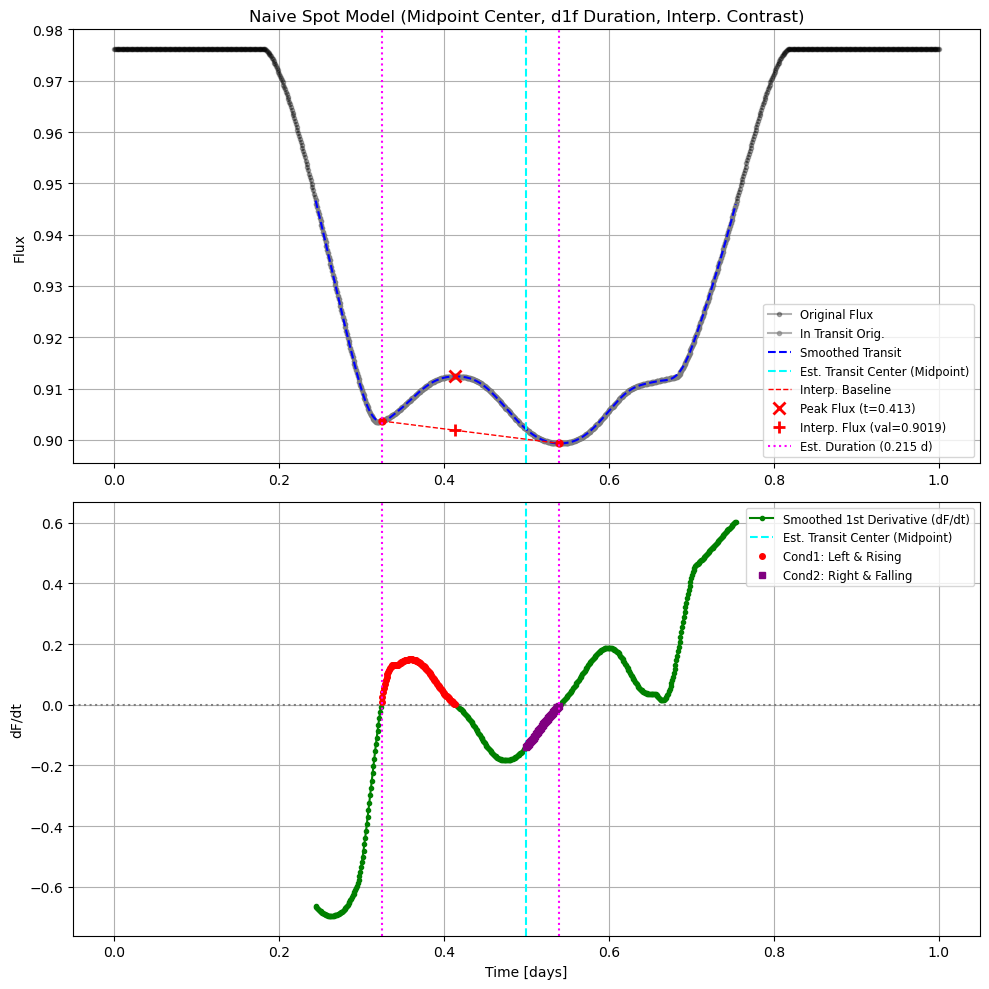

--- Naive Spot Model Finished ---

Summary of Naive Spot Properties (Midpoint Center, d1f Duration, Interp. Contrast):
- center_time: 0.4990
- duration_proxy: 0.2152
- t_start_bump: 0.3243
- t_end_bump: 0.5395
- contrast_proxy: 0.2377


In [56]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter # No longer need find_peaks for this version

#----------------------------------------------------
# 2. Modified Naive Spot Model (Interpolated Contrast)
#----------------------------------------------------
def naive_spot_model_interp_contrast(time, flux, plot_results=True):
    """
    Analyzes a light curve, estimates transit center as midpoint,
    estimates bump duration based on d1f rule, and estimates contrast
    by comparing bump peak to linear interpolation of bump edges.

    Args:
        time (array): Time values of the light curve.
        flux (array): Flux values of the light curve.
        plot_results (bool): If True, plots the analysis steps.

    Returns:
        dict or None: A dictionary containing 'center_time' (transit midpoint),
                      'contrast_proxy' (interp. method),
                      'duration_proxy' (from d1f rule)
                      if a feature and duration are found, otherwise None.
    """
    results = {}
    print("\n--- Running Naive Spot Model (Midpoint Center, d1f Duration, Interp. Contrast) ---")

    # --- Identify Transit (Robust version) ---
    baseline_flux = np.median(flux)
    all_transit_indices = np.where(flux < baseline_flux)[0]
    if len(all_transit_indices) < 10: print("ERROR: Could not clearly identify transit dip."); return None
    blocks = np.split(all_transit_indices, np.where(np.diff(all_transit_indices) != 1)[0]+1)
    longest_block = max(blocks, key=len, default=[])
    if len(longest_block) < 10: print("ERROR: Longest block below baseline too short."); return None
    t_start_contig_idx, t_end_contig_idx = longest_block[0], longest_block[-1]
    t_start_idx = max(0, t_start_contig_idx - 5)
    t_end_idx = min(len(time) - 1, t_end_contig_idx + 5)
    in_transit_time = time[t_start_idx:t_end_idx+1]
    in_transit_flux = flux[t_start_idx:t_end_idx+1]
    if len(in_transit_flux) < 10: print("ERROR: Not enough points in transit after buffering."); return None
    print(f"Identified potential transit region: t=[{in_transit_time[0]:.4f}, {in_transit_time[-1]:.4f}]")

    # --- Smooth the data and Calculate Derivatives ---
    window_length = max(7, int(0.1 * len(in_transit_flux)))
    if window_length % 2 == 0: window_length += 1
    polyorder = 3
    try:
        smoothed_flux = savgol_filter(in_transit_flux, window_length=window_length, polyorder=polyorder)
        d1f_smooth = np.gradient(smoothed_flux, in_transit_time)
        # d2f_smooth = np.gradient(d1f_smooth, in_transit_time) # No longer needed for primary results
    except ValueError as e:
         print(f"ERROR: Smoothing/derivative failed ({e})."); return None

    # --- Estimate Transit Center Time (Midpoint of the identified time range) ---
    transit_center_time = (in_transit_time[0] + in_transit_time[-1]) / 2.0
    results['center_time'] = transit_center_time # Store this as the primary center time now
    print(f"1) Estimated Transit Center Time (Midpoint): {transit_center_time:.4f}")

    # --- Calculate Bump Duration using Derivative Sign Rule ---
    duration_proxy = np.nan
    t_start_bump = np.nan
    t_end_bump = np.nan
    contrast_proxy = np.nan # Initialize contrast
    bump_indices_local = [] # Initialize

    is_left = in_transit_time < transit_center_time
    is_right = in_transit_time > transit_center_time
    is_rising = d1f_smooth > 0
    is_falling = d1f_smooth < 0
    cond1 = is_left & is_rising
    cond2 = is_right & is_falling
    is_bump_region = cond1 | cond2
    bump_indices_local = np.where(is_bump_region)[0]

    if len(bump_indices_local) > 1: # Need at least 2 points for duration & interpolation
        start_bump_idx_local = bump_indices_local[0]
        end_bump_idx_local = bump_indices_local[-1]
        t_start_bump = in_transit_time[start_bump_idx_local]
        t_end_bump = in_transit_time[end_bump_idx_local]
        duration_proxy = t_end_bump - t_start_bump
        print(f"Identified bump region (d1f rule) from t={t_start_bump:.4f} to t={t_end_bump:.4f}")
        print(f"3) Estimated Spot Radius Proxy (Duration from d1f rule): {duration_proxy:.4f} days")

        # --- Calculate Contrast using Interpolation Method ---
        # Find peak *actual flux* within the identified bump region
        peak_idx_within_bump_local_rel = np.argmax(in_transit_flux[bump_indices_local])
        peak_idx_within_bump_local = bump_indices_local[peak_idx_within_bump_local_rel]

        t_peak = in_transit_time[peak_idx_within_bump_local]
        f_peak = in_transit_flux[peak_idx_within_bump_local]

        # Get flux at start and end of bump region
        f_start_bump = in_transit_flux[start_bump_idx_local]
        f_end_bump = in_transit_flux[end_bump_idx_local]

        # Linear interpolation
        f_interp = np.nan
        time_diff = t_end_bump - t_start_bump
        if time_diff > 1e-9: # Avoid division by zero
            f_interp = f_start_bump + (f_end_bump - f_start_bump) * (t_peak - t_start_bump) / time_diff
        else: # Should not happen if len(bump_indices_local) > 1
            f_interp = f_start_bump

        if not np.isnan(f_interp):
            bump_height = f_peak - f_interp
            # Transit depth using smoothed minimum
            transit_bottom_flux = np.min(smoothed_flux)
            transit_depth = baseline_flux - transit_bottom_flux
            if transit_depth > 1e-9:
                contrast_proxy = bump_height / transit_depth
                print(f"   Peak flux in bump region at t={t_peak:.4f}: {f_peak:.6f}")
                print(f"   Interpolated flux at peak time: {f_interp:.6f}")
                print(f"   Bump height (relative to interp.): {bump_height:.2e}")
                print(f"   Transit depth (baseline - min_smooth): {transit_depth:.2e}")
                print(f"2) Estimated Contrast Proxy (Interp. Height / Depth): {contrast_proxy:.4f}")
            else:
                print("2) Transit depth near zero, cannot calculate contrast proxy.")
        else:
             print("2) Could not calculate interpolated flux.")

    else: # Handle cases where no or only one point found in bump region
        if len(bump_indices_local) == 1:
            print("Only one point found in bump region (d1f rule). Cannot calculate duration or interp. contrast.")
        else:
            print("3) No bump region found using the d1f rule.")
        print("2) Contrast proxy not calculated.")


    results['duration_proxy'] = duration_proxy
    results['t_start_bump'] = t_start_bump # Store start/end times as well
    results['t_end_bump'] = t_end_bump
    results['contrast_proxy'] = contrast_proxy


    # --- Plotting ---
    if plot_results:
        plt.figure(figsize=(10, 10))

        # Top plot: Flux and model components
        ax1 = plt.subplot(2, 1, 1)
        plt.plot(time, flux, 'k.-', label='Original Flux', alpha=0.3)
        plt.plot(in_transit_time, in_transit_flux, '.-', color='grey', label='In Transit Orig.', alpha=0.6)
        plt.plot(in_transit_time, smoothed_flux, '--', color='blue', label='Smoothed Transit')
        plt.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center (Midpoint)')

        # Show duration and interpolation points if available
        if len(bump_indices_local) > 1:
            # Plot interpolation line
            plt.plot([t_start_bump, t_end_bump], [f_start_bump, f_end_bump], 'r--', lw=1, label='Interp. Baseline')
            # Mark start/end points used for interpolation
            plt.plot([t_start_bump, t_end_bump], [f_start_bump, f_end_bump], 'ro', ms=5)
            # Mark the peak flux within the bump region
            plt.plot(t_peak, f_peak, 'rx', ms=8, mew=2, label=f'Peak Flux (t={t_peak:.3f})')
            # Mark the interpolated flux value at the peak time
            if not np.isnan(f_interp):
                 plt.plot(t_peak, f_interp, 'r+', ms=8, mew=2, label=f'Interp. Flux (val={f_interp:.4f})')
            # Mark duration lines
            plt.axvline(t_start_bump, color='magenta', linestyle=':', label=f'Est. Duration ({duration_proxy:.3f} d)')
            plt.axvline(t_end_bump, color='magenta', linestyle=':')

        plt.ylabel("Flux")
        plt.title("Naive Spot Model (Midpoint Center, d1f Duration, Interp. Contrast)")
        plt.legend(fontsize='small', loc='lower right')
        plt.grid(True)

        # Bottom plot: First Derivative and Conditions
        ax2 = plt.subplot(2, 1, 2, sharex=ax1)
        plt.plot(in_transit_time, d1f_smooth, '.-', color='green', label='Smoothed 1st Derivative (dF/dt)')
        plt.axhline(0, color='grey', linestyle=':')
        plt.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center (Midpoint)')

        # Highlight points satisfying the conditions
        if len(bump_indices_local) > 0:
            cond1_indices = np.where(cond1)[0]
            cond2_indices = np.where(cond2)[0]
            plt.plot(in_transit_time[cond1_indices], d1f_smooth[cond1_indices], 'o', color='red', ms=4, label='Cond1: Left & Rising')
            plt.plot(in_transit_time[cond2_indices], d1f_smooth[cond2_indices], 's', color='purple', ms=4, label='Cond2: Right & Falling')
            # Mark duration lines on derivative plot
            plt.axvline(t_start_bump, color='magenta', linestyle=':')
            plt.axvline(t_end_bump, color='magenta', linestyle=':')

        plt.ylabel("dF/dt")
        plt.xlabel("Time [days]")
        plt.legend(fontsize='small')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    print("--- Naive Spot Model Finished ---")
    return results

#----------------------------------------------------
# 3. Run the Modified Naive Model
#----------------------------------------------------
spot_info_interp_contrast = naive_spot_model_interp_contrast(time, flux, plot_results=True)

if spot_info_interp_contrast:
    print("\nSummary of Naive Spot Properties (Midpoint Center, d1f Duration, Interp. Contrast):")
    for key, value in spot_info_interp_contrast.items():
         if isinstance(value, float): print(f"- {key}: {value:.4f}")
         else: print(f"- {key}: {value}")
else:
    print("\nNaive model did not detect a qualifying feature or duration.")


--- Running Naive Spot Model (Physical Proxies) ---
Estimated total transit duration: 0.4995 days (from indices 250 to 749)
Using transit region for analysis: t=[0.2452, 0.7548]
1) Estimated Transit Center Time (Midpoint): 0.5000
Identified bump region (d1f rule) from t=0.3243 to t=0.5475
   Bump Duration Proxy: 0.2232 days
Start debugging
duration_proxy: 0.2232232232232232
Total transit duration: 0.49949949949949946
occultor radius: 0.272
end debugging
3) Estimated Spot Radius Proxy (duration_ratio): 0.2431 R*
   Peak flux in bump region at t=0.4134: 0.921201
   Interpolated flux at peak time: 0.910737
   Bump height (relative to interp.): 1.05e-02
   Transit depth (baseline - min_smooth): 4.38e-02
   Naive Contrast Proxy (Height / Depth): 0.2390
   Applying correction factor (Rp/Rspot)^2 = (0.272/0.243)^2 = 1.252
2) Estimated Spot Intensity Proxy: 0.2991


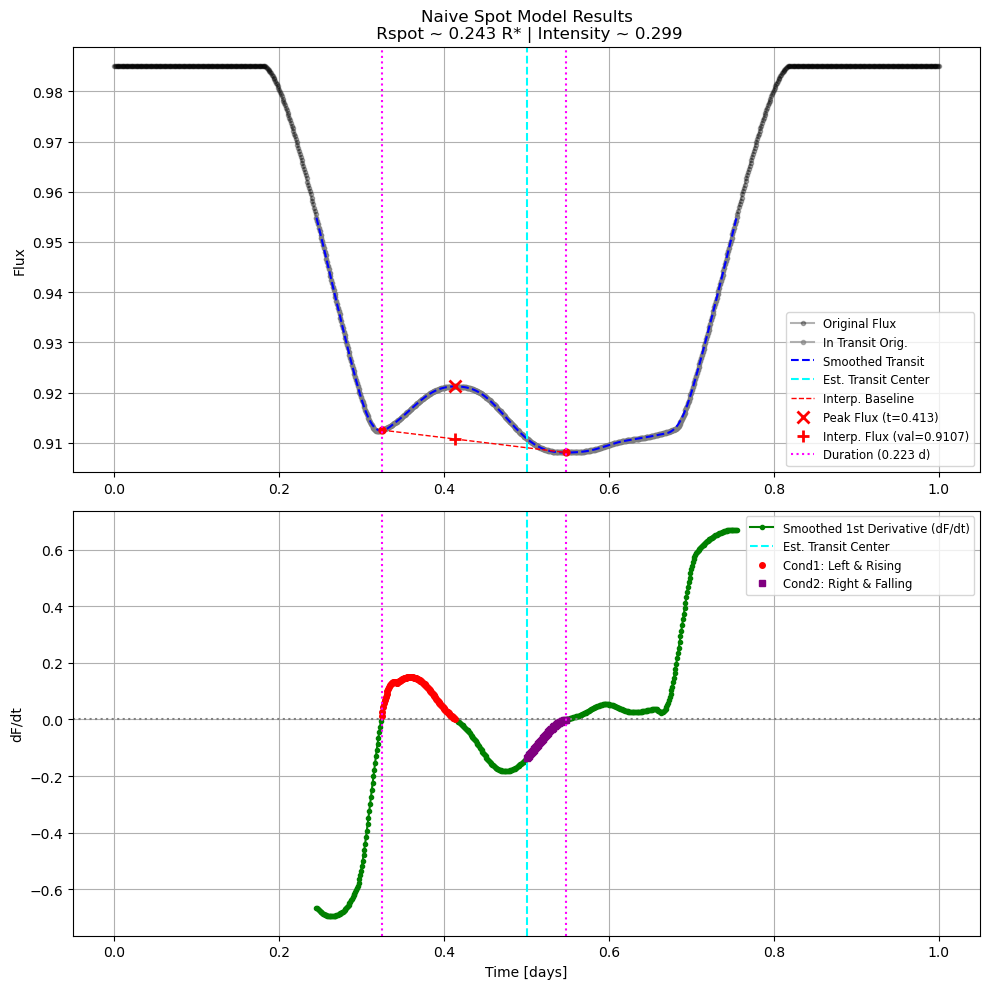

--- Naive Spot Model Finished ---

Summary of Naive Spot Physical Proxies:
- center_time: 0.5000
- duration_proxy: 0.2232
- spot_radius_proxy: 0.2431
- spot_intensity_proxy: 0.2991
- t_start_bump: 0.3243
- t_end_bump: 0.5475


In [4]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


#----------------------------------------------------
# 2. Modified Naive Spot Model (Radius & Intensity Proxy)
#----------------------------------------------------
def naive_spot_model_physical_proxies(time, flux, occultor_radius=0.272, plot_results=True):
    """
    Analyzes a light curve, estimates transit center as midpoint,
    estimates bump duration based on d1f rule, estimates spot radius proxy
    from duration ratio, and estimates intrinsic spot intensity proxy
    by correcting contrast for relative areas.

    Args:
        time (array): Time values of the light curve.
        flux (array): Flux values of the light curve.
        occultor_radius (float): Radius of the planet/occultor in units of R*.
                                 Default is 0.272 (arbitrary example value,
                                 should match the simulated planet radius if known).
        plot_results (bool): If True, plots the analysis steps.

    Returns:
        dict or None: A dictionary containing 'center_time' (transit midpoint),
                      'duration_proxy' (bump duration in days),
                      'spot_radius_proxy' (estimated spot radius in R*),
                      'spot_intensity_proxy' (estimated intrinsic spot contrast),
                      't_start_bump', 't_end_bump'
                      if a feature and duration are found, otherwise None.
    """
    results = {}
    print("\n--- Running Naive Spot Model (Physical Proxies) ---")

    # --- Identify Transit & Duration ---
    baseline_flux = np.median(flux)
    all_transit_indices = np.where(flux < baseline_flux)[0]
    if len(all_transit_indices) < 10: print("ERROR: Could not clearly identify transit dip."); return None
    blocks = np.split(all_transit_indices, np.where(np.diff(all_transit_indices) != 1)[0]+1)
    longest_block = max(blocks, key=len, default=[])
    if len(longest_block) < 10: print("ERROR: Longest block below baseline too short."); return None
    t_start_contig_idx, t_end_contig_idx = longest_block[0], longest_block[-1]

    # Estimate total transit duration (proxy for T14)
    transit_duration_total = np.nan
    if t_end_contig_idx > t_start_contig_idx:
         transit_duration_total = time[t_end_contig_idx] - time[t_start_contig_idx]
         print(f"Estimated total transit duration: {transit_duration_total:.4f} days (from indices {t_start_contig_idx} to {t_end_contig_idx})")
    else:
         print("ERROR: Could not determine total transit duration.")
         return None # Need this for radius proxy

    # Buffer indices for smoothing/derivatives
    t_start_idx = max(0, t_start_contig_idx - 5)
    t_end_idx = min(len(time) - 1, t_end_contig_idx + 5)
    in_transit_time = time[t_start_idx:t_end_idx+1]
    in_transit_flux = flux[t_start_idx:t_end_idx+1]
    if len(in_transit_flux) < 10: print("ERROR: Not enough points in transit after buffering."); return None
    print(f"Using transit region for analysis: t=[{in_transit_time[0]:.4f}, {in_transit_time[-1]:.4f}]")

    # --- Smooth the data and Calculate Derivatives ---
    window_length = max(7, int(0.1 * len(in_transit_flux)))
    if window_length % 2 == 0: window_length += 1
    polyorder = 3
    try:
        smoothed_flux = savgol_filter(in_transit_flux, window_length=window_length, polyorder=polyorder)
        d1f_smooth = np.gradient(smoothed_flux, in_transit_time)
    except ValueError as e:
         print(f"ERROR: Smoothing/derivative failed ({e})."); return None

    # --- Estimate Transit Center Time (Midpoint of buffered range) ---
    transit_center_time = (in_transit_time[0] + in_transit_time[-1]) / 2.0
    results['center_time'] = transit_center_time
    print(f"1) Estimated Transit Center Time (Midpoint): {transit_center_time:.4f}")

    # --- Calculate Bump Duration using Derivative Sign Rule ---
    duration_proxy = np.nan
    t_start_bump = np.nan
    t_end_bump = np.nan
    spot_radius_proxy = np.nan # Initialize
    spot_intensity_proxy = np.nan # Initialize
    bump_indices_local = []

    is_left = in_transit_time < transit_center_time
    is_right = in_transit_time > transit_center_time
    is_rising = d1f_smooth > 0
    is_falling = d1f_smooth < 0
    cond1 = is_left & is_rising
    cond2 = is_right & is_falling
    is_bump_region = cond1 | cond2
    bump_indices_local = np.where(is_bump_region)[0]

    if len(bump_indices_local) > 1:
        start_bump_idx_local = bump_indices_local[0]
        end_bump_idx_local = bump_indices_local[-1]
        t_start_bump = in_transit_time[start_bump_idx_local]
        t_end_bump = in_transit_time[end_bump_idx_local]
        duration_proxy = t_end_bump - t_start_bump # Duration of the bump anomaly
        print(f"Identified bump region (d1f rule) from t={t_start_bump:.4f} to t={t_end_bump:.4f}")
        print(f"   Bump Duration Proxy: {duration_proxy:.4f} days")

        # --- Estimate Spot Radius Proxy ---
        if not np.isnan(transit_duration_total) and transit_duration_total > 1e-9:

            print('Start debugging')
            print('duration_proxy:', duration_proxy)
            print('Total transit duration:', transit_duration_total)
            print('occultor radius:', occultor_radius)
            print('end debugging')

            spot_radius_proxy = (duration_proxy / transit_duration_total) * occultor_radius * 2
            #spot_radius_proxy = duration_proxy / transit_duration_total # Ratio of durations
            print(f"3) Estimated Spot Radius Proxy (duration_ratio): {spot_radius_proxy:.4f} R*")
        else:
            print("3) Cannot estimate spot radius proxy (invalid total transit duration).")


        # --- Calculate Contrast using Interpolation Method & Refine ---
        peak_idx_within_bump_local_rel = np.argmax(in_transit_flux[bump_indices_local])
        peak_idx_within_bump_local = bump_indices_local[peak_idx_within_bump_local_rel]
        t_peak = in_transit_time[peak_idx_within_bump_local]
        f_peak = in_transit_flux[peak_idx_within_bump_local]
        f_start_bump = in_transit_flux[start_bump_idx_local]
        f_end_bump = in_transit_flux[end_bump_idx_local]

        f_interp = np.nan
        time_diff = t_end_bump - t_start_bump
        if time_diff > 1e-9:
            f_interp = f_start_bump + (f_end_bump - f_start_bump) * (t_peak - t_start_bump) / time_diff
        else:
            f_interp = f_start_bump

        if not np.isnan(f_interp):
            bump_height = f_peak - f_interp
            transit_bottom_flux = np.min(smoothed_flux)
            transit_depth = baseline_flux - transit_bottom_flux

            if transit_depth > 1e-9:
                # Naive contrast proxy (height relative to depth)
                contrast_proxy_naive = bump_height / transit_depth
                print(f"   Peak flux in bump region at t={t_peak:.4f}: {f_peak:.6f}")
                print(f"   Interpolated flux at peak time: {f_interp:.6f}")
                print(f"   Bump height (relative to interp.): {bump_height:.2e}")
                print(f"   Transit depth (baseline - min_smooth): {transit_depth:.2e}")
                print(f"   Naive Contrast Proxy (Height / Depth): {contrast_proxy_naive:.4f}")

                # Refine contrast to get intrinsic spot intensity proxy
                correction_factor = 1.0
                if not np.isnan(spot_radius_proxy) and spot_radius_proxy > 1e-9:
                    if spot_radius_proxy < occultor_radius:
                         # Spot smaller than planet: bump suppressed by area ratio
                         correction_factor = (occultor_radius / spot_radius_proxy)**2
                         print(f"   Applying correction factor (Rp/Rspot)^2 = ({occultor_radius:.3f}/{spot_radius_proxy:.3f})^2 = {correction_factor:.3f}")
                    else:
                         # Spot larger than planet: bump limited by planet area, naive proxy approx correct
                         print("   Spot radius >= occultor radius, no correction factor applied.")
                         correction_factor = 1.0

                    spot_intensity_proxy = contrast_proxy_naive * correction_factor
                    print(f"2) Estimated Spot Intensity Proxy: {spot_intensity_proxy:.4f}")
                else:
                    print("2) Cannot calculate spot intensity proxy (invalid spot radius proxy).")
                    spot_intensity_proxy = np.nan # Ensure it's NaN

            else:
                print("2) Transit depth near zero, cannot calculate contrast proxy.")
        else:
             print("2) Could not calculate interpolated flux.")

    else: # Handle cases where no or only one point found in bump region
        if len(bump_indices_local) == 1: print("Only one point found in bump region. Cannot calculate duration/radius/intensity.")
        else: print("No bump region found using the d1f rule.")
        print("2) Contrast/Intensity proxy not calculated.")
        print("3) Spot radius proxy not calculated.")


    # Store results
    results['duration_proxy'] = duration_proxy # Bump duration in days
    results['spot_radius_proxy'] = spot_radius_proxy # Estimated radius in R*
    results['spot_intensity_proxy'] = spot_intensity_proxy # Estimated intrinsic contrast
    results['t_start_bump'] = t_start_bump
    results['t_end_bump'] = t_end_bump


    # --- Plotting (remains the same as previous version) ---
    if plot_results:
        plt.figure(figsize=(10, 10))

        # Top plot: Flux and model components
        ax1 = plt.subplot(2, 1, 1)
        plt.plot(time, flux, 'k.-', label='Original Flux', alpha=0.3)
        plt.plot(in_transit_time, in_transit_flux, '.-', color='grey', label='In Transit Orig.', alpha=0.6)
        plt.plot(in_transit_time, smoothed_flux, '--', color='blue', label='Smoothed Transit')
        plt.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center')

        if len(bump_indices_local) > 1:
            plt.plot([t_start_bump, t_end_bump], [f_start_bump, f_end_bump], 'r--', lw=1, label='Interp. Baseline')
            plt.plot([t_start_bump, t_end_bump], [f_start_bump, f_end_bump], 'ro', ms=5)
            plt.plot(t_peak, f_peak, 'rx', ms=8, mew=2, label=f'Peak Flux (t={t_peak:.3f})')
            if not np.isnan(f_interp):
                 plt.plot(t_peak, f_interp, 'r+', ms=8, mew=2, label=f'Interp. Flux (val={f_interp:.4f})')
            plt.axvline(t_start_bump, color='magenta', linestyle=':', label=f'Duration ({duration_proxy:.3f} d)')
            plt.axvline(t_end_bump, color='magenta', linestyle=':')

        # Add results to title
        title_str = "Naive Spot Model Results\n"
        if not np.isnan(spot_radius_proxy): title_str += f" Rspot ~ {spot_radius_proxy:.3f} R* |"
        if not np.isnan(spot_intensity_proxy): title_str += f" Intensity ~ {spot_intensity_proxy:.3f}"
        plt.title(title_str)
        plt.ylabel("Flux")
        plt.legend(fontsize='small', loc='lower right')
        plt.grid(True)

        # Bottom plot: First Derivative and Conditions
        ax2 = plt.subplot(2, 1, 2, sharex=ax1)
        plt.plot(in_transit_time, d1f_smooth, '.-', color='green', label='Smoothed 1st Derivative (dF/dt)')
        plt.axhline(0, color='grey', linestyle=':')
        plt.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center')
        if len(bump_indices_local) > 0:
            cond1_indices = np.where(cond1)[0]
            cond2_indices = np.where(cond2)[0]
            plt.plot(in_transit_time[cond1_indices], d1f_smooth[cond1_indices], 'o', color='red', ms=4, label='Cond1: Left & Rising')
            plt.plot(in_transit_time[cond2_indices], d1f_smooth[cond2_indices], 's', color='purple', ms=4, label='Cond2: Right & Falling')
            plt.axvline(t_start_bump, color='magenta', linestyle=':')
            plt.axvline(t_end_bump, color='magenta', linestyle=':')
        plt.ylabel("dF/dt")
        plt.xlabel("Time [days]")
        plt.legend(fontsize='small')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    print("--- Naive Spot Model Finished ---")
    return results

#----------------------------------------------------
# 3. Run the Modified Naive Model
#----------------------------------------------------


spot_info_physical = naive_spot_model_physical_proxies(time, flux, occultor_radius=0.272, plot_results=True)
# Or run with the arbitrary default:
# spot_info_physical = naive_spot_model_physical_proxies(time, flux, occultor_radius=0.272, plot_results=True)


if spot_info_physical:
    print("\nSummary of Naive Spot Physical Proxies:")
    for key, value in spot_info_physical.items():
         if isinstance(value, float): print(f"- {key}: {value:.4f}")
         else: print(f"- {key}: {value}") # Should handle NaN properly
else:
    print("\nNaive model did not detect a qualifying feature or duration.")



--- Generating Estimated Spot Map Visualization ---
Plotting with: sigma=0.234 rad, contrast=0.320, lat=0.0, lon=0.0


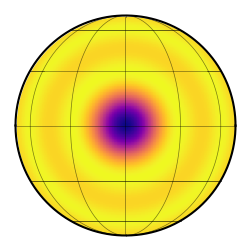

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_estimated_spot_map(results, ydeg_plot=10, inc_plot=90.0, obl_plot=0.0, lat_plot=0.0, lon_plot=0.0, cmap_plot='plasma'):
    """
    Generates a simple starry map visualization based on estimated parameters.

    Args:
        results (dict): Dictionary returned by naive_spot_model_physical_proxies.
                        Must contain 'spot_radius_proxy' and 'spot_intensity_proxy'.
        ydeg_plot (int): Spherical harmonic degree for the plot map.
        inc_plot (float): Inclination for the plot view.
        obl_plot (float): Obliquity for the plot view.
        lat_plot (float): Assumed latitude for the spot [deg].
        lon_plot (float): Assumed longitude for the spot [deg].
        cmap_plot (str): Colormap for the plot.
    """
    print("\n--- Generating Estimated Spot Map Visualization ---")

    radius = results.get('spot_radius_proxy', np.nan)
    contrast = results.get('spot_intensity_proxy', np.nan)

    # Convert radius (R*) to sigma (radians, assuming R*=1)
    # This is an approximation. A Gaussian sigma isn't exactly a hard radius.
    sigma_rad = radius



    print(f"Plotting with: sigma={sigma_rad:.3f} rad, contrast={contrast:.3f}, lat={lat_plot}, lon={lon_plot}")

    try:
        map_plot = starry.Map(ydeg=ydeg_plot, inc=inc_plot, obl=obl_plot) # udeg=0 (no LD)

        # Add the spot based on estimated parameters and assumptions
        map_plot.spot(contrast=contrast, radius=radius)

        # Show the map
        map_plot.show(cmap=cmap_plot, projection='ortho')
        # Get current figure associated with map_plot.show() to add title
        fig = plt.gcf()
        fig.suptitle(f"Estimated Spot Visualization\n(Assumed lat={lat_plot}°, lon={lon_plot}°)")
        # Adjust layout slightly if needed
        # fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
        plt.show()

    except Exception as e:
        print(f"ERROR generating plot map: {e}")

plot_estimated_spot_map(spot_info_physical)


--- Running Naive Spot Model (Static Star Longitude Proxy) ---
Estimated total transit duration: 0.4995 days
Using transit region for analysis: t=[0.2442, 0.7538]
1) Estimated Transit Center Time (Midpoint): 0.4990
Identified bump region (d1f rule) from t=0.3243 to t=0.5395
   Bump Duration Proxy: 0.2152 days
3) Estimated Spot Radius Proxy (R*): 0.1172
   Time diff (t_peak - t_center): -0.0856 days
   Arg for arcsin (2*delta_t / transit_dur): -0.3427
4) Estimated Spot Longitude Proxy (Static Star): -20.04 deg
   Peak flux in bump region at t=0.4134: 0.912354
   Interpolated flux at peak time: 0.901868
   Bump height (relative to interp.): 1.05e-02
   Transit depth (baseline - min_smooth): 4.41e-02
   Naive Contrast Proxy (Height / Depth): 0.2377
   Applying correction factor (Rp/Rspot)^2 = 5.387
2) Estimated Spot Intensity Proxy |ΔI/I|: 1.2805


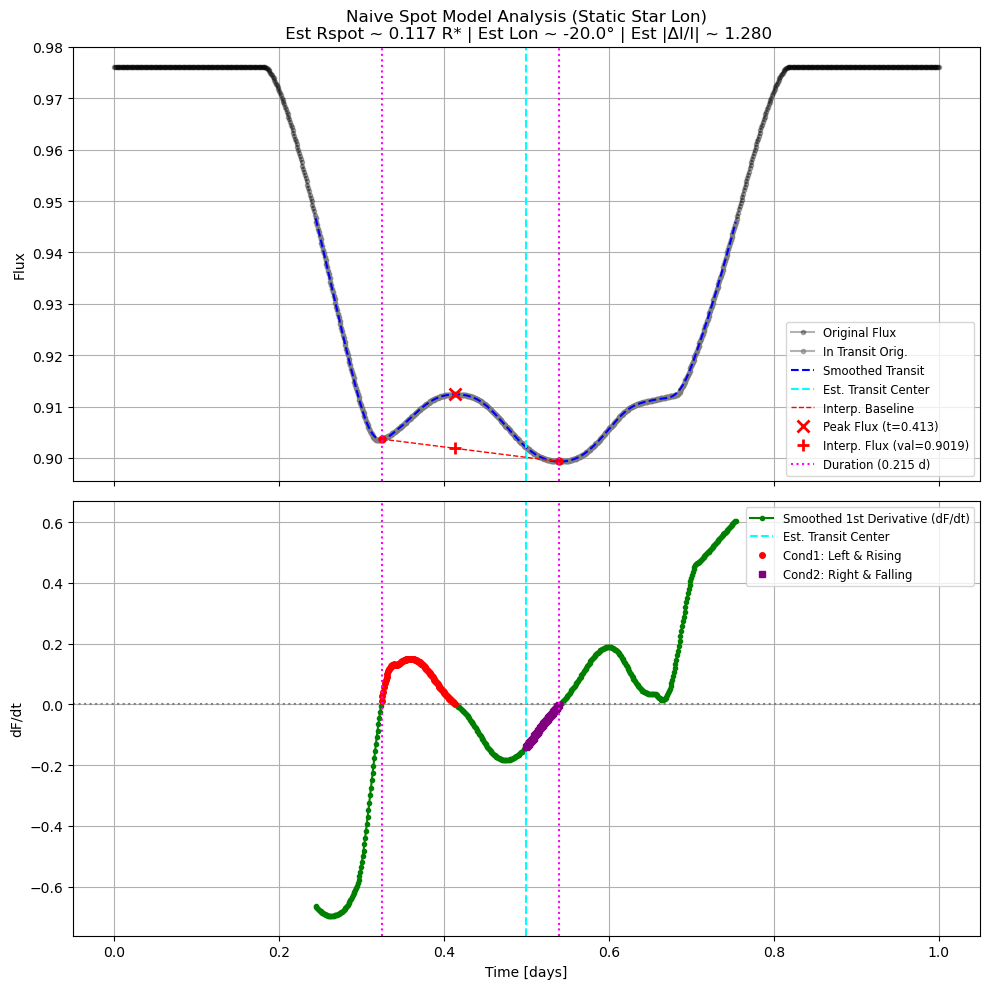


--- Generating Estimated Spot Map Visualization ---
Plotting with: sigma=0.117 rad, intensity=-1.280, lat=0.0, lon=-20.04


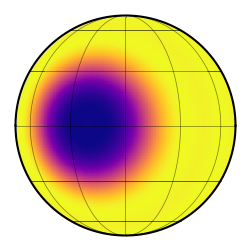

<Figure size 640x480 with 0 Axes>

--- Naive Spot Model Finished ---

Summary of Naive Spot Physical Proxies (Static Star Lon):
- center_time: 0.4990
- duration_proxy: 0.2152
- spot_radius_proxy: 0.1172
- spot_longitude_deg: -20.04
- spot_intensity_proxy: 1.2805
- t_start_bump: 0.3243
- t_end_bump: 0.5395


In [ ]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import warnings # To handle potential arcsin domain errors


#----------------------------------------------------
# 3. Function to Plot Estimated Spot Map (Unchanged)
#----------------------------------------------------
def plot_estimated_spot_map(results, ydeg_plot=10, inc_plot=90.0, obl_plot=0.0, lat_plot=0.0, cmap_plot='plasma'):
    """
    Generates a simple starry map visualization based on estimated parameters.
    Uses estimated longitude if available, otherwise defaults to 0.

    Args:
        results (dict): Dictionary returned by naive_spot_model.
                        Needs 'spot_radius_proxy', 'spot_intensity_proxy'.
                        Uses 'spot_longitude_deg' if available.
        ydeg_plot (int): Spherical harmonic degree for the plot map.
        inc_plot (float): Inclination for the plot view.
        obl_plot (float): Obliquity for the plot view.
        lat_plot (float): Assumed latitude for the spot [deg].
        cmap_plot (str): Colormap for the plot.
    """
    print("\n--- Generating Estimated Spot Map Visualization ---")

    radius = results.get('spot_radius_proxy', np.nan)
    intensity = results.get('spot_intensity_proxy', np.nan)
    lon_plot = results.get('spot_longitude_deg', 0.0)
    if np.isnan(lon_plot): lon_plot = 0.0

    if np.isnan(radius) or np.isnan(intensity):
        print("WARNING: Cannot plot map. Missing estimated radius or intensity.")
        return

    sigma_rad = radius # Approximation Rspot/R* -> sigma(rad)
    intensity_val = -abs(intensity) # Ensure negative for dark spot

    print(f"Plotting with: sigma={sigma_rad:.3f} rad, intensity={intensity_val:.3f}, lat={lat_plot}, lon={lon_plot:.2f}")

    try:
        map_plot = starry.Map(ydeg=ydeg_plot, inc=inc_plot, obl=obl_plot)
        map_plot.add_spot(sigma=sigma_rad, intensity=intensity_val, lat=lat_plot, lon=lon_plot, relative=False)
        map_plot.show(cmap=cmap_plot, projection='ortho')
        fig = plt.gcf()
        fig.suptitle(f"Estimated Spot Visualization\n(Assumed lat={lat_plot}°, Est lon={lon_plot:.1f}°)")
        plt.show()
    except Exception as e:
        print(f"ERROR generating plot map: {e}")


#----------------------------------------------------
# 2. Modified Naive Spot Model (Static Star Longitude)
#----------------------------------------------------
def naive_spot_model_static_lon(time, flux, occultor_radius=0.272, plot_results=True):
    """
    Analyzes a light curve, estimates transit center as midpoint, estimates bump
    duration (d1f rule), spot radius proxy (duration ratio), spot longitude proxy
    (timing offset mapped via arcsin), and intrinsic spot intensity proxy
    (area-corrected contrast). Assumes a static star (no rotation effect on lon).

    Args:
        time (array): Time values of the light curve.
        flux (array): Flux values of the light curve.
        occultor_radius (float): Radius of the planet/occultor in units of R*.
        plot_results (bool): If True, plots the analysis steps & estimated map.

    Returns:
        dict or None: Results dictionary or None.
    """
    results = {}
    print("\n--- Running Naive Spot Model (Static Star Longitude Proxy) ---")

    # --- Identify Transit & Duration ---
    baseline_flux = np.median(flux)
    all_transit_indices = np.where(flux < baseline_flux)[0]
    if len(all_transit_indices) < 10: print("ERROR: Could not clearly identify transit dip."); return None
    blocks = np.split(all_transit_indices, np.where(np.diff(all_transit_indices) != 1)[0]+1)
    longest_block = max(blocks, key=len, default=[])
    if len(longest_block) < 10: print("ERROR: Longest block below baseline too short."); return None
    t_start_contig_idx, t_end_contig_idx = longest_block[0], longest_block[-1]
    transit_duration_total = np.nan
    if t_end_contig_idx > t_start_contig_idx:
         transit_duration_total = time[t_end_contig_idx] - time[t_start_contig_idx]
         print(f"Estimated total transit duration: {transit_duration_total:.4f} days")
    else: print("ERROR: Could not determine total transit duration."); return None
    t_start_idx = max(0, t_start_contig_idx - 5)
    t_end_idx = min(len(time) - 1, t_end_contig_idx + 5)
    in_transit_time = time[t_start_idx:t_end_idx+1]
    in_transit_flux = flux[t_start_idx:t_end_idx+1]
    if len(in_transit_flux) < 10: print("ERROR: Not enough points in transit after buffering."); return None
    print(f"Using transit region for analysis: t=[{in_transit_time[0]:.4f}, {in_transit_time[-1]:.4f}]")

    # --- Smooth the data and Calculate Derivatives ---
    window_length = max(7, int(0.1 * len(in_transit_flux)))
    if window_length % 2 == 0: window_length += 1
    polyorder = 3
    try:
        smoothed_flux = savgol_filter(in_transit_flux, window_length=window_length, polyorder=polyorder)
        d1f_smooth = np.gradient(smoothed_flux, in_transit_time)
    except ValueError as e: print(f"ERROR: Smoothing/derivative failed ({e})."); return None

    # --- Estimate Transit Center Time ---
    transit_center_time = (in_transit_time[0] + in_transit_time[-1]) / 2.0
    results['center_time'] = transit_center_time
    print(f"1) Estimated Transit Center Time (Midpoint): {transit_center_time:.4f}")

    # --- Calculate Bump Duration, Proxies ---
    duration_proxy = np.nan; t_start_bump = np.nan; t_end_bump = np.nan
    spot_radius_proxy = np.nan; spot_intensity_proxy = np.nan; spot_longitude_deg = np.nan
    bump_indices_local = []; t_peak = np.nan; f_peak = np.nan; f_interp = np.nan
    f_start_bump = np.nan; f_end_bump = np.nan; cond1 = None; cond2 = None

    is_left = in_transit_time < transit_center_time
    is_right = in_transit_time > transit_center_time
    is_rising = d1f_smooth > 0
    is_falling = d1f_smooth < 0
    cond1 = is_left & is_rising
    cond2 = is_right & is_falling
    is_bump_region = cond1 | cond2
    bump_indices_local = np.where(is_bump_region)[0]

    if len(bump_indices_local) > 1:
        start_bump_idx_local = bump_indices_local[0]
        end_bump_idx_local = bump_indices_local[-1]
        t_start_bump = in_transit_time[start_bump_idx_local]
        t_end_bump = in_transit_time[end_bump_idx_local]
        duration_proxy = t_end_bump - t_start_bump
        print(f"Identified bump region (d1f rule) from t={t_start_bump:.4f} to t={t_end_bump:.4f}")
        print(f"   Bump Duration Proxy: {duration_proxy:.4f} days")

        # --- Estimate Spot Radius Proxy ---
        if not np.isnan(transit_duration_total) and transit_duration_total > 1e-9:
            spot_radius_proxy = occultor_radius * (duration_proxy / transit_duration_total)
            print(f"3) Estimated Spot Radius Proxy (R*): {spot_radius_proxy:.4f}")
        else: print("3) Cannot estimate spot radius proxy.")

        # Find peak flux time within bump for contrast & longitude
        peak_idx_within_bump_local_rel = np.argmax(in_transit_flux[bump_indices_local])
        peak_idx_within_bump_local = bump_indices_local[peak_idx_within_bump_local_rel]
        t_peak = in_transit_time[peak_idx_within_bump_local]

        # --- Estimate Longitude (Static Star Assumption) ---
        if not np.isnan(t_peak) and not np.isnan(transit_duration_total) and transit_duration_total > 1e-9:
            delta_t = t_peak - transit_center_time
            # Argument maps relative time offset to sin(longitude)
            arg_arcsin = 2.0 * delta_t / transit_duration_total
            print(f"   Time diff (t_peak - t_center): {delta_t:.4f} days")
            print(f"   Arg for arcsin (2*delta_t / transit_dur): {arg_arcsin:.4f}")

            # Check domain for arcsin and calculate longitude
            if abs(arg_arcsin) <= 1.0:
                 # Use warnings context manager for arcsin edge cases
                 with warnings.catch_warnings():
                    warnings.simplefilter("ignore", RuntimeWarning) # Ignore invalid value in arcsin
                    spot_longitude_deg = np.arcsin(arg_arcsin) * (180.0 / np.pi)
                 if np.isnan(spot_longitude_deg): # Should not happen if abs(arg)<=1, but check anyway
                     print("4) Warning: Arcsin calculation resulted in NaN.")
                 else:
                     print(f"4) Estimated Spot Longitude Proxy (Static Star): {spot_longitude_deg:.2f} deg")
            else:
                 print(f"4) Warning: Cannot estimate longitude. Bump peak time (offset {delta_t:.3f} d) is outside the estimated transit duration ({transit_duration_total:.3f} d). Implies arg arcsin > 1.")
                 spot_longitude_deg = np.nan # Set to NaN if outside valid range
        else:
            print("4) Cannot estimate longitude (missing t_peak or transit_duration).")


        # --- Calculate Contrast using Interpolation Method & Refine ---
        f_peak = in_transit_flux[peak_idx_within_bump_local]
        f_start_bump = in_transit_flux[start_bump_idx_local]
        f_end_bump = in_transit_flux[end_bump_idx_local]
        time_diff = t_end_bump - t_start_bump
        if time_diff > 1e-9: f_interp = f_start_bump + (f_end_bump - f_start_bump) * (t_peak - t_start_bump) / time_diff
        else: f_interp = f_start_bump

        if not np.isnan(f_interp):
            bump_height = f_peak - f_interp
            transit_bottom_flux = np.min(smoothed_flux)
            transit_depth = baseline_flux - transit_bottom_flux
            if transit_depth > 1e-9:
                contrast_proxy_naive = bump_height / transit_depth
                print(f"   Peak flux in bump region at t={t_peak:.4f}: {f_peak:.6f}")
                print(f"   Interpolated flux at peak time: {f_interp:.6f}")
                print(f"   Bump height (relative to interp.): {bump_height:.2e}")
                print(f"   Transit depth (baseline - min_smooth): {transit_depth:.2e}")
                print(f"   Naive Contrast Proxy (Height / Depth): {contrast_proxy_naive:.4f}")

                correction_factor = 1.0
                if not np.isnan(spot_radius_proxy) and spot_radius_proxy > 1e-9:
                    if spot_radius_proxy < occultor_radius:
                         correction_factor = (occultor_radius / spot_radius_proxy)**2
                         print(f"   Applying correction factor (Rp/Rspot)^2 = {correction_factor:.3f}")
                    else: print("   Spot radius >= occultor radius, no correction.")
                    spot_intensity_proxy = contrast_proxy_naive * correction_factor
                    print(f"2) Estimated Spot Intensity Proxy |ΔI/I|: {spot_intensity_proxy:.4f}")
                else: print("2) Cannot calc intensity proxy (invalid Rspot).")
            else: print("2) Transit depth near zero, cannot calc contrast.")
        else: print("2) Could not calculate interpolated flux.")
    else:
        if len(bump_indices_local) == 1: print("Only one point found in bump region.")
        else: print("No bump region found using the d1f rule.")
        print("2/3/4) Contrast/Intensity/Radius/Longitude proxies not calculated.")

    # Store main results
    results['duration_proxy'] = duration_proxy
    results['spot_radius_proxy'] = spot_radius_proxy
    results['spot_longitude_deg'] = spot_longitude_deg # Store static longitude proxy
    results['spot_intensity_proxy'] = spot_intensity_proxy
    results['t_start_bump'] = t_start_bump
    results['t_end_bump'] = t_end_bump
    # Store intermediate results needed for plotting
    results['_t_peak'] = t_peak
    results['_f_peak'] = f_peak
    results['_f_interp'] = f_interp
    results['_f_start_bump'] = f_start_bump
    results['_f_end_bump'] = f_end_bump
    results['_bump_indices_local'] = bump_indices_local
    results['_cond1'] = cond1
    results['_cond2'] = cond2

    # --- Plotting ---
    if plot_results:
        # (Plotting code remains exactly the same as the previous version)
        fig1, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
        ax1 = axes[0]; ax2 = axes[1]
        ax1.plot(time, flux, 'k.-', label='Original Flux', alpha=0.3)
        ax1.plot(in_transit_time, in_transit_flux, '.-', color='grey', label='In Transit Orig.', alpha=0.6)
        ax1.plot(in_transit_time, smoothed_flux, '--', color='blue', label='Smoothed Transit')
        ax1.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center')
        if len(bump_indices_local) > 1:
            ax1.plot([t_start_bump, t_end_bump], [f_start_bump, f_end_bump], 'r--', lw=1, label='Interp. Baseline')
            ax1.plot([t_start_bump, t_end_bump], [f_start_bump, f_end_bump], 'ro', ms=5)
            if not np.isnan(t_peak): ax1.plot(t_peak, f_peak, 'rx', ms=8, mew=2, label=f'Peak Flux (t={t_peak:.3f})')
            if not np.isnan(f_interp): ax1.plot(t_peak, f_interp, 'r+', ms=8, mew=2, label=f'Interp. Flux (val={f_interp:.4f})')
            if not np.isnan(duration_proxy): ax1.axvline(t_start_bump, color='magenta', linestyle=':', label=f'Duration ({duration_proxy:.3f} d)')
            ax1.axvline(t_end_bump, color='magenta', linestyle=':')
        title_str = "Naive Spot Model Analysis (Static Star Lon)\n"
        if not np.isnan(spot_radius_proxy): title_str += f" Est Rspot ~ {spot_radius_proxy:.3f} R* |"
        if not np.isnan(spot_longitude_deg): title_str += f" Est Lon ~ {spot_longitude_deg:.1f}° |"
        if not np.isnan(spot_intensity_proxy): title_str += f" Est |ΔI/I| ~ {spot_intensity_proxy:.3f}"
        ax1.set_title(title_str)
        ax1.set_ylabel("Flux"); ax1.legend(fontsize='small', loc='lower right'); ax1.grid(True)
        ax2.plot(in_transit_time, d1f_smooth, '.-', color='green', label='Smoothed 1st Derivative (dF/dt)')
        ax2.axhline(0, color='grey', linestyle=':')
        ax2.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center')
        if len(bump_indices_local) > 0 and cond1 is not None and cond2 is not None:
            cond1_indices = np.where(cond1)[0]; cond2_indices = np.where(cond2)[0]
            ax2.plot(in_transit_time[cond1_indices], d1f_smooth[cond1_indices], 'o', color='red', ms=4, label='Cond1: Left & Rising')
            ax2.plot(in_transit_time[cond2_indices], d1f_smooth[cond2_indices], 's', color='purple', ms=4, label='Cond2: Right & Falling')
            if not np.isnan(duration_proxy): ax2.axvline(t_start_bump, color='magenta', linestyle=':'); ax2.axvline(t_end_bump, color='magenta', linestyle=':')
        ax2.set_ylabel("dF/dt"); ax2.set_xlabel("Time [days]")
        ax2.legend(fontsize='small'); ax2.grid(True)
        fig1.tight_layout(); plt.show()
        plot_estimated_spot_map(results)

    print("--- Naive Spot Model Finished ---")
    return results

#----------------------------------------------------
# 4. Run the Model
#----------------------------------------------------
spot_info = naive_spot_model_static_lon(time, flux,
                                        occultor_radius=0.272,
                                        plot_results=True) # No prot needed

if spot_info:
    print("\nSummary of Naive Spot Physical Proxies (Static Star Lon):")
    print(f"- center_time: {spot_info.get('center_time', np.nan):.4f}")
    print(f"- duration_proxy: {spot_info.get('duration_proxy', np.nan):.4f}")
    print(f"- spot_radius_proxy: {spot_info.get('spot_radius_proxy', np.nan):.4f}")
    print(f"- spot_longitude_deg: {spot_info.get('spot_longitude_deg', np.nan):.2f}") # Static Lon
    print(f"- spot_intensity_proxy: {spot_info.get('spot_intensity_proxy', np.nan):.4f}")
    print(f"- t_start_bump: {spot_info.get('t_start_bump', np.nan):.4f}")
    print(f"- t_end_bump: {spot_info.get('t_end_bump', np.nan):.4f}")
else:
    print("\nNaive model did not detect a qualifying feature or duration.")
